<a href="https://colab.research.google.com/github/wtergan/openai-to-z-amazon/blob/main/Checkpoint_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Checkpoint 2: Anomaly Detection with GEDI, PRODES, SRTM, LiDAR & Sentinel-2**

This notebook implements a full pipeline for detecting anomalous archaeological features in the Amazon. It integrates multiple remote sensing datasets, performs advanced feature engineering, scores potential anomalies, and uses a Large Language Model (LLM) for a final contextual assessment.

The process for each is:

1. Setup: Install libraries and configure API keys.
2. Configuration: Define the region of interest (bounding box), year, and other pipeline parameters.
3. Data Fetching:
    - Fetch GEDI, PRODES, and SRTM data for fine-grained, per-cell analysis.
    - Fetch regional LiDAR and Sentinel-2 imagery for broader context.
4. Feature Extraction & Engineering:
    - Extract visual features and statistics from LiDAR and Sentinel-2 data.
    - Process GEDI, PRODES, and SRTM data into a rich feature set for each H3 hexagonal cell.
5. Anomaly Detection:
    - Score each cell based on its features to identify potential anomalies.
    - Rank the cells to find the top N most anomalous candidates.
6. LLM-Powered Analysis:
    - Regional Assessment: The LLM first analyzes the regional LiDAR and Sentinel-2 imagery to provide a high-level summary of the area's characteristics.
    - Per-Cell Assessment: The LLM then assesses each of the top N anomalous cells, using the regional assessment for context, to determine its archaeological potential.
7. Results: Display the regional summary and the detailed assessment for each top-ranked cell.

### Setup and API Key Configuration

This section installs all required Python packages. It also sets up authentication for Google Earth Engine (GEE) and the LLM providers (OpenAI/OpenRouter), as well as configuration for the pipeline.

In [1]:
# ===============================================================================
# INSTALLING DEPENDENCIES
# ===============================================================================
!pip install -q numpy pandas scipy geopandas shapely h3 owslib scikit-learn earthengine-api requests urllib3 pyarrow python-dotenv laspy rasterio matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.8/985.8 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 31.9 MB/s eta 0:00:00


In [2]:
# ===============================================================================
# IMPORTING LIBRARIES
# ===============================================================================
import os
import json
import logging
import time
import hashlib
import tempfile
import h3
import zipfile
import base64
import urllib.request
import io
from pathlib import Path
from typing import Dict, Any, Optional, Tuple, List
from urllib.parse import urljoin
from functools import lru_cache
from datetime import datetime
from getpass import getpass

import ee
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import box, Point, Polygon
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from PIL import Image
from dotenv import load_dotenv
from owslib.wfs import WebFeatureService
from IPython.display import display, Image as IPImage, JSON, Markdown

import numpy as np
import laspy
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats

from openai import OpenAI, OpenAIError

In [3]:
# ===============================================================================
# API KEY CONFIGURATION
# ===============================================================================
logging.basicConfig(level=logging.INFO, format="%(message)s")
logger = logging.getLogger(__name__)

# Loading the environment variables from .env file:
try:
    load_dotenv()
    logger.info(".env file loaded.")
except Exception as e:
    logger.warning(f"Could not load .env file: {e}. Please enter keys manually.")

# Setting up API keys and GEE Project ID:
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
OT_API_KEY = os.getenv("OT_API_KEY")
GEE_PROJECT_ID = os.getenv("GEE_PROJECT_ID")

if not OPENAI_API_KEY:
    OPENAI_API_KEY = getpass("Enter your OpenAI API Key: ")
if not OPENROUTER_API_KEY:
    OPENROUTER_API_KEY = getpass("Enter your OpenRouter API Key: ")
if not OT_API_KEY:
    OT_API_KEY = getpass("Enter your OpenTopography API Key: ")
if not GEE_PROJECT_ID:
    GEE_PROJECT_ID = getpass("Enter your GEE Project ID: ")

# Initializing Google Earth Engine:
gee_initialized_successfully = False
def initialize_gee():
    """Initialize Google Earth Engine with proper authentication handling."""
    global gee_initialized_successfully
    if gee_initialized_successfully:
        return True
    try:
        logger.info("Attempting GEE initialization...")
        if GEE_PROJECT_ID:
            ee.Initialize(project=GEE_PROJECT_ID, opt_url='https://earthengine.googleapis.com')
        else:
            ee.Initialize(opt_url='https://earthengine.googleapis.com')
        logger.info("GEE initialized successfully.")
        gee_initialized_successfully = True
    except ee.EEException as e_init:
        logger.warning(f"GEE auto-initialization failed: {e_init}. Attempting authentication flow.")
        try:
            ee.Authenticate()
            if GEE_PROJECT_ID:
                ee.Initialize(project=GEE_PROJECT_ID, opt_url='https://earthengine.googleapis.com')
            else:
                ee.Initialize(opt_url='https://earthengine.googleapis.com')
            logger.info("GEE authenticated and initialized successfully.")
            gee_initialized_successfully = True
        except Exception as e_auth:
            logger.error(f"CRITICAL: GEE authentication and initialization failed: {e_auth}")
            gee_initialized_successfully = False
    return gee_initialized_successfully

# Initializing GEE right away:
initialize_gee()

Enter your OpenAI API Key: ··········
Enter your OpenRouter API Key: ··········
Enter your OpenTopography API Key: ··········
Enter your GEE Project ID: ··········



earthengine authenticate

in your command line, or ee.Authenticate() in Python, and then retry.. Attempting authentication flow.


True

### Pipeline Configuration:

Setting up pertinent parameters for the assessment pipeline:
- BBOX: The bounding box [min_lon, min_lat, max_lon, max_lat] for the area of interest.
- YEAR: The year for which to analyze data.
- TOP_N: The number of top anomalies to analyze with the LLM.
- LLM_PROVIDER: Choose between 'openrouter' or 'openai'.
- LLM_MODEL: Specify the model to use (e.g., 'google/gemma-3-27b-it' for OpenRouter, 'gpt-4o-mini' for OpenAI).
- FORCE_REFRESH: Set to True to re-download all data, ignoring cache.

In [4]:
# ===============================================================================
# PIPELINE CONFIGURATION
# ===============================================================================

# Default coordinates for current pipeline (Amazonas, Brazil), subject to change of course.
S2_DEFAULT_SOUTH = -5.253821
S2_DEFAULT_NORTH = -3.983349
S2_DEFAULT_WEST = -59.813892
S2_DEFAULT_EAST = -58.332325
S2_DEFAULT_START_DATE = "2022-01-01"
S2_DEFAULT_END_DATE = "2022-12-31"

# Bounding Box for Amazonas, Brazil (min_lon, min_lat, max_lon, max_lat)
BBOX_COORDS = [-59.813892, -5.253821, -58.332325, -3.983349]

# Year for analysis
YEAR = 2022

# Number of top anomalies to send to LLM
TOP_N = 3

# LLM Configuration
LLM_PROVIDER = 'openrouter' # 'openai' or 'openrouter'
LLM_MODEL = 'google/gemma-3-27b-it' # Or 'gpt-4o-mini' etc.

# Data Caching
CACHE_DIR = "data/raw"
FORCE_REFRESH = False # Set to True to re-download all data
SHOW_IMAGES = True # Set to False to suppress matplotlib plots

# --- Helper Functions ---
def make_bbox(min_lon, min_lat, max_lon, max_lat):
    """Construct a bounding box as a dict."""
    return {
        'min_lon': min_lon, 'min_lat': min_lat,
        'max_lon': max_lon, 'max_lat': max_lat
    }

# Create the bounding box object
BBOX = make_bbox(*BBOX_COORDS)

# Create cache directory if it doesn't exist
Path(CACHE_DIR).mkdir(parents=True, exist_ok=True)

print("Configuration set:")
print(f"BBOX: {BBOX}")
print(f"YEAR: {YEAR}")
print(f"TOP_N: {TOP_N}")
print(f"LLM Provider: {LLM_PROVIDER}")
print(f"LLM Model: {LLM_MODEL}")

Configuration set:
BBOX: {'min_lon': -59.813892, 'min_lat': -5.253821, 'max_lon': -58.332325, 'max_lat': -3.983349}
YEAR: 2022
TOP_N: 3
LLM Provider: openrouter
LLM Model: google/gemma-3-27b-it


### Data Fetchiing WorkFlow:

All of the pertinent functions needed for the data fetching workflow:
Functions for:
- bbox to ee.Geometry, Shapely polygon functions.
- functions for reusable requests session and generation of cache directories for the data.
- functions for fetching LiDAR and Sentinel-2 data.
- functions for fetching GEDI, PRODES, and SRTM data.
- pipelines for efficient fetching and retrieval of the LiDAR/Sentinel-2 and GEDI/PRODES/SRTM data

In [5]:
# ===============================================================================
# BBOX FUNCTIONS
# ===============================================================================
def bbox_to_polygon(bbox):
    """Convert bbox dict to Shapely polygon."""
    return box(bbox['min_lon'], bbox['min_lat'], bbox['max_lon'], bbox['max_lat'])

def bbox_to_ee_geometry(bbox):
    """Convert bbox dict to Earth Engine geometry."""
    return ee.Geometry.Rectangle([
        bbox['min_lon'], bbox['min_lat'], bbox['max_lon'], bbox['max_lat']
    ])

# ===============================================================================
# REQUESTS SESSION AND CACHE HELPERS
# ===============================================================================
def get_requests_session():
    """Create a reusable requests session with retry strategy."""
    session = requests.Session()
    retry_strategy = Retry(
        total=3,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["HEAD", "GET", "OPTIONS"],
        backoff_factor=1
    )
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session.mount("http://", adapter)
    session.mount("https://", adapter)
    # Set a default User-Agent
    session.headers.update({"User-Agent": "openai-to-z/0.1 (Dataset fetcher)"})
    return session

def ensure_cache_dir(cache_dir):
    """Ensure the cache directory exists, creating it if necessary."""
    cache_path = Path(cache_dir)
    cache_path.mkdir(parents=True, exist_ok=True)
    return cache_path

def generate_cache_key(bbox, year, dataset):
    """
    Generate a cache key based on bbox, year, and dataset.
    Converts key data to a sorted json string, then returns a md5 hash of the string.
    """
    key_data = {
        "bbox": [bbox['min_lon'], bbox['min_lat'], bbox['max_lon'], bbox['max_lat']],
        "year": year,
        "dataset": dataset,
        "version": "1.0"
    }
    key_string = json.dumps(key_data, sort_keys=True)
    return hashlib.md5(key_string.encode()).hexdigest()

def get_cache_path(cache_dir, cache_key, dataset, ext=".csv"):
    """Get the full cache path for a given dataset and cache key."""
    return Path(cache_dir) / f"{dataset}_{cache_key}{ext}"

In [6]:
# ===============================================================================
# LIDAR DATA FETCHING (OpenTopography API)
# ===============================================================================
def fetch_lidar_ot_data(demtype: str, south: float, north: float, west: float, east: float,
    api_key=OT_API_KEY) -> Optional[str]:
    """
    Download a LiDAR .tif file from OpenTopography API.
    Takes in the available global raster dataset type (demtype), the bbox coordinates,
    and returns the path to the downloaded temporary file.
    """
    url = "https://portal.opentopography.org/API/globaldem"
    params = {
        "demtype": demtype,
        "south": south,
        "north": north,
        "west": west,
        "east": east,
        "outputFormat": "GTiff",
        "API_Key": api_key
    }
    try:
        tf = tempfile.NamedTemporaryFile(suffix=".tif", delete=False)
        resp = requests.get(url, params=params, timeout=120)
        resp.raise_for_status()
        tf.write(resp.content)
        tf.close()
        logger.info(f"LiDAR data successfully downloaded to temporary file: {tf.name}")
        return tf.name
    except Exception as e:
        logger.error(f"Error downloading LiDAR data: {e}")
        return None

# ===============================================================================
# SENTINEL-2 DATA FETCHING AND PROCESSING (Google Earth Engine)
# ===============================================================================
def cloud_mask_s2_sr(image: ee.Image) -> ee.Image:
    """Cloud mask creation for Sentinel-2 Surface Reflectance using SCL band."""
    scl = image.select('SCL')
    # Mask out cloud shadow, medium/high probability cloud, and cirrus, saturated/defective pixels:
    clear_mask = scl.neq(1).And(scl.neq(3)).And(scl.neq(8)).And(scl.neq(9)).And(scl.neq(10))
    valid_data_mask = image.select('B2').gt(0)
    return image.updateMask(clear_mask.And(valid_data_mask)).divide(10000) # Scale data to 0-1 range.

def fetch_sentinel2_gee_data(
    south: float, north: float, west: float, east: float, start_date: str, end_date: str,
    max_cloud_percentage: float = 20.0
) -> Optional[Dict[str, Any]]:
    """
    Fetching Sentinel-2 L2A median composite from GEE (Copernicus/S2_SR_HARMONIZED) for a given bbox and date range.
    Returns a dictionary containing the GEE image object and ROI.
    """
    if not gee_initialized_successfully:
        if not initialize_gee():
            raise RuntimeError("GEE could not be initialized. Cannot fetch Sentinel-2 data.")
    roi = ee.Geometry.Rectangle([west, south, east, north])

    # Filtering ImageCollection by ROI, date range, as well as cloud percentage:
    s2_collection = (
        ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
        .filterBounds(roi)
        .filterDate(ee.Date(start_date), ee.Date(end_date))
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", max_cloud_percentage))
    )
    count = s2_collection.size().getInfo()
    if count == 0:
        logger.warning(f"No Sentinel-2 images found for the given criteria in GEE.")
        logger.warning(f"ROI: {west},{south},{east},{north}")
        logger.warning(f"Date: {start_date} to {end_date}, Cloud %: < {max_cloud_percentage}")
        return {"image": None, "roi": roi, "count": 0, "error": "No images found"}
    logger.info(f"Found {count} Sentinel-2 images. Creating median composite...")

    # All 12 multispectral bands in S2_SR_HARMONIZED... B10, which is used to detech cirrus clouds and used
    # for atomospheric correction purposes in L1C data, is not included in L2A, since its already atmos corrected.
    all_spectral_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']

    # Creating median composite via applying cloud/valid mask, selecting defined bands, and clipping to ROI:
    composite_image = (
        s2_collection.map(cloud_mask_s2_sr)
        .select(all_spectral_bands)
        .median()
        .clip(roi)
    )
    # Lets check if the median composite image is valid: if no band names, all pixels masked, thus empty. Not good.
    try:
        composite_image.bandNames().getInfo()
    except ee.EEException as e:
        logger.error(f"Error creating valid GEE composite (likely all pixels masked): {e}")
        return {"image": None, "roi": roi, "count": count, "error": "Composite image is empty/invalid."}
    logger.info(f"Sentinel-2 GEE median composite created for period {start_date} to {end_date}.")
    return {
        "image": composite_image,
        "roi": roi,
        "count": count,
        "start_date": start_date,
        "end_date": end_date,
        "roi_bounds": [west, south, east, north],
        "bands_included": all_spectral_bands
    }

In [7]:
# ==============================================================================
# SRTM DATA FETCHING AND PROCESSING (Google Earth Engine)
# ==============================================================================
def fetch_srtm(bbox, cache_dir="data/raw", force_refresh=False, sample_scale=30):
    """
    Fetch SRTM elevation data within the bounding box and compute slope metrics.
    Returns a DataFrame with columns: lon, lat, elevation, slope_degrees, aspect_degrees.
    Uses Google Earth Engine for data access.
    """
    ensure_cache_dir(cache_dir)
    cache_year = 2000 # SRTM is static, thus using a fixed 2000 year for caching purposes.
    cache_key = generate_cache_key(bbox, cache_year, "srtm")
    cache_path = get_cache_path(cache_dir, cache_key, "srtm")
    if not force_refresh and cache_path.exists():
        logger.info(f"Loading SRTM data from cache: {cache_path}")
        try:
            return pd.read_csv(cache_path)
        except Exception as e:
            logger.warning(f"Failed to load from cache: {e}")
    logger.info(f"Fetching SRTM elevation and slope data via Google Earth Engine")
    try:
        # Initialize Earth Engine if needed:
        if not gee_initialized_successfully:
            if not initialize_gee():
                logger.error("Failed to initialize Google Earth Engine for SRTM data")
                return pd.DataFrame(columns=['lon', 'lat', 'elevation', 'slope_degrees', 'aspect_degrees'])
        # Loading SRTM elevation data (30m), selecting elevation band, then computing slope and aspect in degrees:
        srtm = ee.Image('USGS/SRTMGL1_003')
        elevation = srtm.select('elevation')
        slope = ee.Terrain.slope(elevation)
        aspect = ee.Terrain.aspect(elevation)

        # Combining elevation, slope, and aspect into a single image:
        terrain_image = elevation.addBands([slope, aspect]).rename(['elevation', 'slope_degrees', 'aspect_degrees'])

        # Computing the appropriate bbox area to determine the optimal number of pixels to sample:
        bbox_geometry = bbox_to_ee_geometry(bbox)
        area_km2 = bbox_geometry.area().divide(1000000).getInfo()  # Convert to km²

        # Conservative sampling to avoid GEE limits - use lower density for larger areas:
        if area_km2 > 1000:  # Large area
            target_density = 100
        elif area_km2 > 100:  # Medium area
            target_density = 300
        else:  # Small area
            target_density = 500

        optimal_pixels = int(area_km2 * target_density)
        # Strict bounds to avoid GEE collection limits:
        num_pixels = max(100, min(optimal_pixels, 3000))  # Much lower max limit
        logger.info(f"Sampling {num_pixels} pixels for the bbox area of {area_km2:.2f} km²")

        samples = terrain_image.sample(
            region=bbox_geometry,
            scale=sample_scale,
            numPixels=num_pixels,
            seed=42,
            geometries=True
        )
        # Checking if there are any raster samples found:
        raster_data = samples.getInfo()
        if not raster_data['features']:
            logger.warning("No SRTM elevation data found for the specified bbox")
            return pd.DataFrame(columns=['lon', 'lat', 'elevation', 'slope_degrees', 'aspect_degrees'])

        # Constructing a records list from the raster_data features:
        records = []
        for feature in raster_data['features']:
            props = feature['properties']
            coords = feature['geometry']['coordinates']
            record = {
                'lon': coords[0],
                'lat': coords[1],
                'elevation': props.get('elevation'),
                'slope_degrees': props.get('slope_degrees'),
                'aspect_degrees': props.get('aspect_degrees')
            }
            records.append(record)

        # Constructing a pandas DataFrame from the records list, filtering out invalid coords, rasters outside bbox:
        df = pd.DataFrame(records)
        df = df.dropna(subset=['lon', 'lat', 'elevation'])
        df = df[(df['lon'] >= bbox['min_lon']) & (df['lon'] <= bbox['max_lon'])]
        df = df[(df['lat'] >= bbox['min_lat']) & (df['lat'] <= bbox['max_lat'])]
        df = df.round(4) # Rounding values for consistency.
        logger.info(f"Fetched {len(df)} SRTM elevation points with terrain metrics")
        logger.info(f"Elevation range: {df['elevation'].min():.1f} - {df['elevation'].max():.1f} m")
        logger.info(f"Slope range: {df['slope_degrees'].min():.1f} - {df['slope_degrees'].max():.1f} degrees")

        # Caching the DataFrame to a CSV file for further usage:
        df.to_csv(cache_path, index=False)
        logger.info(f"Cached SRTM data to: {cache_path}")
        return df
    except Exception as e:
        logger.error(f"Failed to fetch SRTM data: {e}")
        return pd.DataFrame(columns=['lon', 'lat', 'elevation', 'slope_degrees', 'aspect_degrees'])

In [8]:
# ==============================================================================
# GEDI DATA FETCHING AND PROCESSING (Google Earth Engine)
# ==============================================================================
def fetch_gedi(bbox, year, cache_dir="data/raw", force_refresh=False):
    """
    Fetch GEDI L2A vector shots within the bounding box for the specified year.
    Uses Google Earth Engine for data access. Filters for quality_flag == 1
    and removes shots with invalid coordinates or missing canopy height.
    Returns DataFrame with columns: lon, lat, rh98, canopy_height, quality_flag, shot_number
    Note: canopy_height is mapped from rh100, lat/lon from lat_highestreturn/lon_highestreturn
    """
    ensure_cache_dir(cache_dir)
    cache_key = generate_cache_key(bbox, year, "gedi")
    cache_path = get_cache_path(cache_dir, cache_key, "gedi")

    if not force_refresh and cache_path.exists():
        logger.info(f"Loading GEDI data from cache: {cache_path}")
        try:
            return pd.read_csv(cache_path)
        except Exception as e:
            logger.warning(f"Failed to load from cache: {e}")

    logger.info(f"Fetching GEDI L2A vector data for year {year} via Google Earth Engine")

    try:
        # Initialize Earth Engine if needed:
        if not gee_initialized_successfully:
            if not initialize_gee():
                logger.error("Failed to initialize Google Earth Engine for GEDI data")
                return pd.DataFrame(columns=['lon', 'lat', 'rh98', 'canopy_height', 'quality_flag', 'shot_number'])

        # Usage of GEDI L2A table index to find available data tables; creating date filter for the specified year:
        gedi_index = ee.FeatureCollection("LARSE/GEDI/GEDI02_A_002_INDEX")
        start_date = f"{year}-01-01"
        end_date = f"{year + 1}-01-01"

        # Filtering the index by date and bounds to find relevant tables, then getting the list of table IDs:
        bbox_geometry = bbox_to_ee_geometry(bbox)
        relevant_tables = (gedi_index
                          .filter(ee.Filter.And(
                              ee.Filter.gte('time_start', start_date),
                              ee.Filter.lte('time_end', end_date)
                          ))
                          .filterBounds(bbox_geometry))
        table_info = relevant_tables.getInfo()
        if not table_info['features']:
            logger.warning("No GEDI tables found for the specified bbox and year")
            return pd.DataFrame(columns=['lon', 'lat', 'rh98', 'canopy_height', 'quality_flag', 'shot_number'])
        logger.info(f"Found {len(table_info['features'])} GEDI tables for the specified period")

        # Computing the optimal sampling based on bbox area:
        area_km2 = bbox_geometry.area().divide(1000000).getInfo()
        target_density = 1000
        optimal_samples = int(area_km2 * target_density)
        max_samples = min(optimal_samples, 50000)  # GEE limit consideration:
        samples_per_table = max(100, max_samples // len(table_info['features']))
        logger.info(f"Sampling up to {samples_per_table} shots per table for bbox area of {area_km2:.2f} km²")

        # Collecting data from all relevant tables:
        all_records = []
        for table_feature in table_info['features']:
            table_id = table_feature['properties']['table_id']
            try:
                # Loading the specific GEDI table (table_id already includes full path):
                gedi_table = ee.FeatureCollection(table_id)
                # Filtering by bounds and quality:
                gedi_filtered = (gedi_table
                               .filterBounds(bbox_geometry)
                               .filter(ee.Filter.eq('quality_flag', 1)))

                # Selecting only the fields we need:
                gedi_selected = gedi_filtered.select([
                    'lat_highestreturn', 'lon_highestreturn',  # Correct coordinate fields.
                    'rh98', 'rh100', 'quality_flag', 'shot_number'
                ])

                # Sampling the table if it's too large:
                table_size = gedi_selected.size().getInfo()
                if table_size > samples_per_table:
                    gedi_sampled = gedi_selected.randomColumn('random').sort('random').limit(samples_per_table)
                else:
                    gedi_sampled = gedi_selected

                # Getting the data:
                table_data = gedi_sampled.getInfo()
                if table_data['features']:
                    all_records.extend(table_data['features'])
                    logger.info(f"Collected {len(table_data['features'])} shots from table {table_id}")

            except Exception as e:
                logger.warning(f"Failed to process table {table_id}: {e}")
                continue

        if not all_records:
            logger.warning("No GEDI shots found after processing all tables")
            return pd.DataFrame(columns=['lon', 'lat', 'rh98', 'canopy_height', 'quality_flag', 'shot_number'])
        logger.info(f"Total collected: {len(all_records)} GEDI shots from {len(table_info['features'])} tables")

        # Extracting records from features:
        records = []
        for feature in all_records:
            props = feature['properties']

            # Skipping if any critical values are null:
            if (props.get('rh98') is None or
                props.get('rh100') is None or
                props.get('lat_highestreturn') is None or
                props.get('lon_highestreturn') is None):
                continue

            record = {
                'lon': props.get('lon_highestreturn'),  # Map from lon_highestreturn
                'lat': props.get('lat_highestreturn'),  # Map from lat_highestreturn
                'rh98': props.get('rh98'),
                'canopy_height': props.get('rh100'),  # Map rh100 to canopy_height for compatibility
                'quality_flag': props.get('quality_flag', 1),
                'shot_number': props.get('shot_number')
            }
            records.append(record)

        # Creating a DataFrame and filtering:
        df = pd.DataFrame(records)
        if df.empty:
            logger.warning("No valid GEDI records after filtering")
            return df

        # Additional spatial filtering and data cleaning:
        df = df.dropna(subset=['lon', 'lat', 'rh98', 'canopy_height'])
        df = df[(df['lon'] >= bbox['min_lon']) & (df['lon'] <= bbox['max_lon'])]
        df = df[(df['lat'] >= bbox['min_lat']) & (df['lat'] <= bbox['max_lat'])]

        logger.info(f"Fetched {len(df)} quality GEDI shots")

        # Caching the results:
        df.to_csv(cache_path, index=False)
        logger.info(f"Cached GEDI data to: {cache_path}")

        return df

    except Exception as e:
        logger.error(f"Failed to fetch GEDI data: {e}")
        return pd.DataFrame(columns=['lon', 'lat', 'rh98', 'canopy_height', 'quality_flag', 'shot_number'])

In [9]:
# ==============================================================================
# PRODES DATA FETCHING AND PROCESSING (TerraBrasilis API)
# ==============================================================================
def fetch_prodes(bbox, year, cache_dir="data/raw", force_refresh=False):
    """
    Fetch PRODES deforestation polygons from TerraBrasilis.

    This function automatically downloads and extracts the source GeoPackage file if it's
    not found locally. It then filters the data for the specified year and bounding
    box, caching the final filtered result as a GeoJSON for fast subsequent access.
    """
    ensure_cache_dir(cache_dir)
    cache_key = generate_cache_key(bbox, year, "prodes")
    cache_path = get_cache_path(cache_dir, cache_key, "prodes", ".geojson")

    if not force_refresh and cache_path.exists():
        logger.info(f"Loading PRODES data from cache: {cache_path}")
        try:
            return gpd.read_file(cache_path)
        except Exception as e:
            logger.warning(f"Failed to load from cache: {e}")

    # Define paths for the source GeoPackage and its zipped version
    geopackage_path = Path(cache_dir) / "prodes_amazonia_nb.gpkg"
    zip_url = "https://terrabrasilis.dpi.inpe.br/download/dataset/amz-prodes/vector/prodes_amazonia_nb.gpkg.zip"
    zip_path = Path(cache_dir) / "prodes_amazonia_nb.gpkg.zip"

    # --- New Download & Unzip Logic ---
    # If the main GeoPackage file doesn't exist, download and extract it.
    if not geopackage_path.exists():
        logger.info(f"Source PRODES GeoPackage not found at: {geopackage_path}")
        logger.info(f"Downloading from {zip_url}...")
        try:
            # Download the file with a timeout
            with requests.get(zip_url, stream=True, timeout=300) as r: # 5-minute timeout
                r.raise_for_status()
                with open(zip_path, 'wb') as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        f.write(chunk)
            logger.info("Download complete.")

            # Unzip the file
            logger.info(f"Extracting {zip_path}...")
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(path=cache_dir)
            logger.info(f"Successfully extracted GeoPackage to {cache_dir}")

            # Clean up the downloaded zip file to save space
            os.remove(zip_path)
            logger.info(f"Removed temporary zip file: {zip_path}")

        except requests.exceptions.RequestException as e:
            logger.error(f"Failed to download PRODES data: {e}")
            return gpd.GeoDataFrame(columns=['geometry', 'year', 'area_ha'])
        except zipfile.BadZipFile as e:
            logger.error(f"Failed to extract PRODES GeoPackage from zip: {e}")
            return gpd.GeoDataFrame(columns=['geometry', 'year', 'area_ha'])
        except Exception as e:
            logger.error(f"An unexpected error occurred during PRODES data setup: {e}")
            return gpd.GeoDataFrame(columns=['geometry', 'year', 'area_ha'])
    # --- End of New Logic ---

    if not geopackage_path.exists():
        logger.error(f"PRODES GeoPackage not found at: {geopackage_path}")
        return gpd.GeoDataFrame(columns=['geometry', 'year', 'area_ha'])

    try:
        logger.info(f"Loading GeoPackage from: {geopackage_path}")
        # Load the yearly deforestation layer specifically
        layer_name = 'yearly_deforestation_biome'
        gdf = gpd.read_file(geopackage_path, layer=layer_name)
        logger.info(f"Loaded GeoPackage layer '{layer_name}' with {len(gdf)} total polygons")

        # Filter by year
        gdf_year = gdf[gdf['year'] == year]
        logger.info(f"Filtered to {len(gdf_year)} polygons for year {year}")

        if gdf_year.empty:
            logger.warning(f"No PRODES polygons found for year {year}")
            return gpd.GeoDataFrame(columns=['geometry', 'year', 'area_ha'])

        # Create bbox polygon for spatial filtering and clip
        bbox_polygon = bbox_to_polygon(bbox)
        gdf_clipped = gdf_year[gdf_year.geometry.intersects(bbox_polygon)]
        logger.info(f"After bbox filtering: {len(gdf_clipped)} polygons")

        if gdf_clipped.empty:
            logger.warning(f"No PRODES polygons found within bbox {bbox} for year {year}")
            return gpd.GeoDataFrame(columns=['geometry', 'year', 'area_ha'])

        # Select and prepare final columns
        gdf_result = gdf_clipped[['geometry', 'year', 'area_ha']].copy()

        # Cache the filtered result as GeoJSON
        gdf_result.to_file(cache_path, driver='GeoJSON')
        logger.info(f"Fetched {len(gdf_result)} PRODES polygons covering {gdf_result['area_ha'].sum():.1f} hectares")
        logger.info(f"Cached filtered PRODES data to: {cache_path}")

        return gdf_result

    except Exception as e:
        logger.error(f"Failed to load or process PRODES data from GeoPackage: {e}")
        return gpd.GeoDataFrame(columns=['geometry', 'year', 'area_ha'])

In [10]:
# ==============================================================================
# FETCH PIPELINE FOR GEDI, PRODES, and SRTM
# ==============================================================================
def gedi_prodes_srtm_fetch_pipeline(bbox: dict = None, year: int = 2022, cache_dir="data/raw", force_refresh: bool = False):
    """
    Fetching pipeline for the GEDI, PRODES, and SRTM datasets for the specified bbox and year.
    If bbox and/or year is None, uses the default coordinates and/or year.
    Returns a tuple of the GEDI and SRTM DataFrames, as well as the PRODES GeoDataFrame.
    force_refresh determines whether to force a refresh of the cached data. Defaults to 'False'.
    GEDI data comes from 'GEDI L2A Raster Canopy Top Height (Version 2, Monthly)', via Google Earth Engine (GEE).
        - https://developers.google.com/earth-engine/datasets/catalog/LARSE_GEDI_GEDI02_A_002_MONTHLY#description
    PRODES data comes from 'TerraBrasilis Native Vegetation Suppression Map (PRODES)', loaded from local GeoPackage file.
        - Source: https://terrabrasilis.dpi.inpe.br/app/map/deforestation?hl=en
    SRTM data comes from 'NASA SRTM Digital Elevation V3', via Google Earth Engine (GEE).
        - https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003
    """
    # Use default coordinates, created via make_box function for easy plugin; useful for test runs:
    if bbox is None:
        bbox = make_bbox(S2_DEFAULT_WEST, S2_DEFAULT_SOUTH, S2_DEFAULT_EAST, S2_DEFAULT_NORTH)
    # If bbox is already a proper dict with the required keys, use it as-is
    # Otherwise, assume it needs to be properly formatted

    # Retrieving the GEDI data; if there is no data for the specified bbox/year, function will return empty DataFrame:
    logger.info(f"FETCHING GEDI L2A RASTER CANOPY TOP HEIGHT V2 DATA FROM GEE FOR THE FOLLOWING BBOX:\n{bbox}\nYEAR:{year}\n")
    gedi_df = fetch_gedi(bbox, year, cache_dir, force_refresh)
    if gedi_df.empty is True:
        logger.warning("FETCH DID NOT RETURN ANY DATA. THERE WAS AN ERROR IN THE FETCHING PROCESS OR NO DATA AVAILABLE \
            FOR THE SPECIFIED BBOX AND YEAR.\n")

    # Retrieving the PRODES data; if there is no data for the specified bbox/year, function will return empty DataFrame:
    logger.info(f"FETCHING PRODES DATA FROM LOCAL GEOPACKAGE FOR THE FOLLOWING BBOX:\n{bbox}\nYEAR:{year}\n")
    prodes_gdf = fetch_prodes(bbox, year, cache_dir, force_refresh)
    if prodes_gdf.empty is True:
        logger.warning("FETCH DID NOT RETURN ANY DATA. THERE WAS AN ERROR IN THE FETCHING PROCESS OR NO DATA AVAILABLE \
            FOR THE SPECIFIED BBOX AND YEAR.\n")

    # Retrieving the SRTM data; if there is no data for the specified bbox/year, function will return empty DataFrame:
    logger.info(f"FETCHING SRTM DATA FROM GEE FOR THE FOLLOWING BBOX:\n{bbox}\n")
    srtm_df = fetch_srtm(bbox, cache_dir, force_refresh)
    if srtm_df.empty is True:
        logger.warning("FETCH DID NOT RETURN ANY DATA. THERE WAS AN ERROR IN THE FETCHING PROCESS OR NO DATA AVAILABLE \
            FOR THE SPECIFIED BBOX AND YEAR.\n")

    # Returning some preliminary data for debugging, informational purposes:
    logger.info(f"GEDI_PRODES_SRTM_FETCH_PIPELINE COMPLETED. RETURNING THE FOLLOWING DATA:\n\
        GEDI Shots: {len(gedi_df)}\n\
        PRODES Polygons: {len(prodes_gdf)}\n\
        SRTM Points: {len(srtm_df)}")

    # Finally, returning the LiDAR and Sentinel-2 data for further processing and usage:
    return gedi_df, prodes_gdf, srtm_df

# ==============================================================================
# FETCHING PIPELINE FOR LIDAR AND SENTINEL-2
# ==============================================================================
def lidar_sentinel2_fetch_pipeline(bbox: dict = None) -> dict:
    """
    Fetching pipeline for the LiDAR and Sentinel-2 datasets, given a specified bounding box (bbox).
    If bbox is None, uses the default coordinates.
    Returns a dict with the LiDAR file path (GeoTIFF data) and the Sentinel-2 GEE median composite image and ROI.
    LiDAR data comes from 'Copernicus Global Digital Elevation Models' (COP30), via OpenTopography API.
        - https://portal.opentopography.org/datasetMetadata?otCollectionID=OT.032021.4326.1
    Sentinel-2 data comes from 'Copernicus Harmonnized Sentinel-2 MSI: MultiSpectral Instrument, Level-2A (SR)', via Google Earth Engine (GEE).
        - https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED
    """
    logger.info(f"FETCHING LIDAR DATA FROM COP30 (OpenTopography API) FOR THE FOLLOWING BBOX:\n{bbox}\n")
    # Use default coordinates; useful for test runs:
    if bbox is None:
        south, north = S2_DEFAULT_SOUTH, S2_DEFAULT_NORTH
        west, east = S2_DEFAULT_WEST, S2_DEFAULT_EAST
    # Use the specified bbox coordinates:
    else:
        south, north = bbox['min_lat'], bbox['max_lat']
        west, east = bbox['min_lon'], bbox['max_lon']

    # Retrieving the LiDAR data; if there is no data for the specified bbox, set to None but continue.
    lidar_path = fetch_lidar_ot_data(demtype="COP30", south=south, north=north, west=west, east=east)

    # Retrieving the Sentinel-2 data; if there is no data for the specified bbox, set to None but continue:
    print(f"FETCHING SENTINEL-2 COMPOSITE DATA FROM COPERNICUS S2 SR HARMONIZED (GEE) FOR THE FOLLOWING BBOX:\n{bbox}\n")
    s2_data = fetch_sentinel2_gee_data(
            south=south, north=north, west=west, east=east,
            start_date=S2_DEFAULT_START_DATE, end_date=S2_DEFAULT_END_DATE
        )

    # Only return None if both data sources failed
    if lidar_path is None and s2_data is None:
        logger.warning("Both LiDAR and Sentinel-2 data fetching failed")
        return None

    # Returning some preliminary data for debugging, informational purposes:
    logger.info(f"LIDAR and SENTINEL-2 FETCHING COMPLETED. RETURNING THE FOLLOWING DATA:\n\
        LiDAR Path: {lidar_path}\n\
        Sentinel-2 Data: {s2_data}")

    # Finally, returning the LiDAR and Sentinel-2 data for further processing and usage:
    return {
        'lidar_path': lidar_path,
        's2_data': s2_data
    }

### Feature Extraction Workflow:

Generate and displays plots of the LiDAR data, as well as some LiDAR stats. Then, generation of band and NDVI stats for the Sentinel-2 data, then generation of RGB, NDVI and false-color thumbnails for displaying.

In [11]:
# ===============================================================================
# LiDAR FEATURE EXTRACTION: OpenTopography API
# ===============================================================================
def lidar_ot_extract_features(lidar_path: str, show_image: bool = True) -> Optional[Dict[str, Any]]:
    """
    Generate and display a plots of LiDAR GeoTIFF data along with some stats.
    Returns a dict containing the plot as a BytesIO obj, and the stats.
    Cleans up the temporary lidar_path file upon completion or error.
    """
    try:
        with rasterio.open(lidar_path) as src:
            print("LiDAR data read.")
            lidar_arr = src.read(1).astype(np.float32)
            if src.nodata is not None:
                lidar_arr = np.where(lidar_arr == src.nodata, np.nan, lidar_arr)
            if np.all(np.isnan(lidar_arr)):
                print("Error: LiDAR data is empty or all NoData values.")
                return None

            # Usage of 2-98 percentiles for avoiding outliers that may affect color mapping:
            vmin, vmax = np.nanpercentile(lidar_arr, [2, 98])

            # Figure with subplots:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
            fig.suptitle("LiDAR Data Analysis", fontsize=16)

            # Main elevation plot:
            print("Generating LiDAR elevation plot...")
            im1 = ax1.imshow(lidar_arr, cmap='terrain', vmin=vmin, vmax=vmax)
            plt.colorbar(im1, ax=ax1, label='Elevation (m)')
            ax1.set_title("LiDAR Elevation Data (2-98% range)")

            # Hillshade for better terrain visualization, using LightSource for azimuth and altitude:
            print("Generating LiDAR hillshade...")
            ls = LightSource(azdeg=315, altdeg=45)
            hillshade = ls.hillshade(lidar_arr, vert_exag=1, dx=src.res[0], dy=src.res[1], fraction=1.0)
            ax2.imshow(hillshade, cmap='gray', alpha=0.8)
            ax2.set_title("Hillshade Visualization")

            # Show the plot if show_image is True:
            print("Displaying the plot(s)...")
            if show_image:
                plt.show()

            # Save plot to BytesIO buffer as JPEG, tight bbox, 150 DPI:
            print("Saving plot to BytesIO buffer...")
            buf = io.BytesIO()
            plt.tight_layout()
            plt.savefig(buf, format="JPEG", bbox_inches="tight", dpi=150)
            plt.close()
            buf.seek(0)

            # Binary to base64 conversion:
            print("Converting plot to base64 and computation of stats...")
            image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8')

            # Compiling results:
            ot_stats = {
                "image": image_base64,
                "statistics": {
                    "mean": float(np.nanmean(lidar_arr)),
                    "median": float(np.nanmedian(lidar_arr)),
                    "std": float(np.nanstd(lidar_arr)),
                    "min": float(np.nanmin(lidar_arr)),
                    "max": float(np.nanmax(lidar_arr)),
                    "percentile_2": float(vmin),
                    "percentile_98": float(vmax),
                    "shape": lidar_arr.shape
                },
                # Some spatial metadata: coordinate reference system, and bbox info:
                "crs": str(src.crs) if src.crs else "N/A",
                "bounds": list(src.bounds)
            }
            buf.close()
            return ot_stats
    except Exception as e:
        print(f"Error processing LiDAR data: {e}")
        return None
    finally:
        # Clean up the temporary file:
        if os.path.exists(lidar_path):
            os.unlink(lidar_path)
            print(f"Temporary file {lidar_path} deleted.")


In [12]:
# ===============================================================================
# Sentinel-2 FEATURE EXTRACTION: Google Earth Engine
# ===============================================================================
def sentinel2_gee_extract_features(
    gee_data: dict,
    scale: int = 20, #Compromised resolution for all multispectral bands.
    thumb_dimensions: str = '768x768', # Thumbnail dimensions.
    show_image: bool = True
) -> Optional[Dict[str, Any]]:
    """
    Computing stats for all 12 multispectral bands and generating multiple visualizations for a
    Sentinel-2 GEE Image.
    Reminder: B10 is not included in the GEE Image being used here, due to it not being included in
    the L2A data, since its already atmospherically corrected.
    Returns a dict containing RGB composite, NDVI heatmap, false-color composite as base64,
    along with comprehensive statistics and metadata for future AI analysis.
    """
    if not gee_data or not gee_data.get("image"):
        error_msg = gee_data.get("error", "GEE image not provided or invalid.")
        print(f"Error: {error_msg}")
        return {
            "rgb_image": None,
            "statistics": {"error": error_msg},
            "roi_bounds": gee_data.get("roi_bounds"),
            "gee_image_details": "No image processed."
        }

    image = gee_data["image"]
    roi = gee_data["roi"]
    roi_bounds = gee_data["roi_bounds"]

    # Creating a composite reducer that computes multiple stats all in one operation:
    reducers = (
        ee.Reducer.mean().unweighted()
        .combine(ee.Reducer.minMax().unweighted(), sharedInputs=True)
        .combine(ee.Reducer.stdDev().unweighted(), sharedInputs=True)
        .combine(ee.Reducer.percentile([2, 98]).unweighted(), sharedInputs=True)
        .combine(ee.Reducer.count().unweighted(), sharedInputs=True)
    )
    # All 12 pertinent multispectral bands from Sentinel-2 will be used for full coverage:
    all_spectral_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
    try:
        # Computation of the stats for each selected band, given image, ROI, scale, and reducers:
        print(f"Calculating stats for bands: {all_spectral_bands} at {scale}m scale...")
        band_stats = image.select(all_spectral_bands).reduceRegion(
            reducer=reducers,
            geometry=roi,
            scale=scale,
            maxPixels=1e10,
            tileScale=4
        ).getInfo()
        print("Band stats received.")
    except ee.EEException as e:
        print(f"GEE Error calculating band stats: {e}")
        return {
            "rgb_image": None,
            "statistics": {"error": f"GEE band stats error: {e}"},
            "roi_bounds": roi_bounds,
            "gee_image_details": "Failed during band statistics."
        }
    except Exception as e_gen:
        print(f"General Error calculating band stats: {e_gen}")
        return {
            "rgb_image": None,
            "statistics": {"error": f"General band stats error: {e_gen}"},
            "roi_bounds": roi_bounds,
            "gee_image_details": "Failed during band statistics."
        }

    # Calculating NDVI (Normalized Difference Vegetation Index) and its stats:
    # NDVI is computed as (NIR - Red) / (NIR + Red), where NIR=near-infrared, band 8, and Red is band 4.
    ndvi_stats = {}
    try:
        print("Computing Normalized Difference Vegetation Index (NDVI)...")
        ndvi_image = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        ndvi_stats_raw = ndvi_image.reduceRegion(
            reducer=reducers,
            geometry=roi,
            scale=scale,
            maxPixels=1e10,
            tileScale=4
        ).getInfo()
        print("NDVI stats received.")
        for key, value in ndvi_stats_raw.items():
            ndvi_stats[f"NDVI_{key}"] = value
    except ee.EEException as e:
        print(f"GEE Error calculating NDVI stats: {e}")
    except Exception as e_gen:
        print(f"General Error calculating NDVI stats: {e_gen}")

    # Merging the stats from all bands and NDVI into a single dict for usage:
    all_stats = {}
    for band in all_spectral_bands:
        for stat_key, reducer_key_part in {
            "mean": "mean", "min": "min", "max": "max", "std": "stdDev",
            "p2": "p2", "p98": "p98", "count": "count" }.items():
            gee_key = f"{band}_{reducer_key_part}"
            all_stats[f"{band}_{stat_key}"] = band_stats.get(gee_key)
    all_stats.update(ndvi_stats)

    # Initializing variables for the image thumbnails:
    rgb_image_base64 = None
    ndvi_image_base64 = None
    false_color_image_base64 = None
    rgb_pil_image = None
    ndvi_pil_image = None
    false_color_pil_image = None

    # Generating the RGB composite thumbnail for LLM processing:
    try:
        print("Generating RGB composite thumbnail...")
        # Vis params for 0-1 scaled reflectance. Common S2 vis is 0-0.3 range.
        rgb_vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0.0, 'max': 0.3, 'gamma': 1.4}
        region_payload = roi.getInfo()['coordinates'] if hasattr(roi, 'getInfo') else roi
        rgb_thumbnail_url = image.visualize(**rgb_vis_params).getThumbURL({
            'region': region_payload,
            'dimensions': thumb_dimensions,
            'format': 'jpg'
        })

        # Downloading and processing the thumbnail; binary to base64 conversion:
        print(f"RGB composite thumbnail URL (first 100 chars): {rgb_thumbnail_url[:100]}...")
        with urllib.request.urlopen(rgb_thumbnail_url, timeout=60) as response:
            img_data = response.read()
        rgb_pil_image = Image.open(io.BytesIO(img_data))
        buf = io.BytesIO()
        rgb_pil_image.save(buf, format="JPEG")
        buf.seek(0)
        rgb_image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8')
        buf.close()
        print("RGB composite thumbnail generated and encoded.")

    except ee.EEException as e:
        print(f"GEE Error generating RGB composite thumbnail: {e}")
    except urllib.error.URLError as e_url:
        print(f"URL Error downloading RGB composite thumbnail: {e_url}")
    except Exception as e_thumb:
        print(f"General error generating RGB composite thumbnail: {e_thumb}")

    # Generating NDVI heatmap visualization:
    try:
        print("Generating NDVI heatmap visualization...")
        # NDVI visualization parameters: red-yellow-green scale for vegetation health
        # Green/yellow for healthy vegetation (0.3-1.0), red/brown for bare soil/stress (-1.0-0.3)
        ndvi_vis_params = {
            'bands': ['NDVI'],
            'min': -0.2,
            'max': 0.8,
            'palette': ['8B4513', 'CD853F', 'DEB887', 'F0E68C', 'ADFF2F', '32CD32', '228B22']  # Brown to green
        }

        ndvi_thumbnail_url = ndvi_image.visualize(**ndvi_vis_params).getThumbURL({
            'region': region_payload,
            'dimensions': thumb_dimensions,
            'format': 'jpg'
        })

        print(f"NDVI thumbnail URL (first 100 chars): {ndvi_thumbnail_url[:100]}...")
        with urllib.request.urlopen(ndvi_thumbnail_url, timeout=60) as response:
            ndvi_img_data = response.read()
        ndvi_pil_image = Image.open(io.BytesIO(ndvi_img_data))
        ndvi_buf = io.BytesIO()
        ndvi_pil_image.save(ndvi_buf, format="JPEG")
        ndvi_buf.seek(0)
        ndvi_image_base64 = base64.b64encode(ndvi_buf.getvalue()).decode('utf-8')
        ndvi_buf.close()
        print("NDVI heatmap generated and encoded.")

    except ee.EEException as e:
        print(f"GEE Error generating NDVI heatmap: {e}")
        ndvi_image_base64 = None
    except urllib.error.URLError as e_url:
        print(f"URL Error downloading NDVI heatmap: {e_url}")
        ndvi_image_base64 = None
    except Exception as e_ndvi:
        print(f"General error generating NDVI heatmap: {e_ndvi}")
        ndvi_image_base64 = None

    # Generating false-color composite (NIR-Red-Green):
    try:
        print("Generating false-color composite (NIR-Red-Green)...")
        # False-color visualization: NIR->Red, Red->Green, Green->Blue
        # Vegetation appears red/pink, water appears blue/black, urban appears cyan/blue
        false_color_vis_params = {
            'bands': ['B8', 'B4', 'B3'],  # NIR, Red, Green mapped to RGB
            'min': 0.0,
            'max': 0.3,
            'gamma': 1.2
        }

        false_color_thumbnail_url = image.visualize(**false_color_vis_params).getThumbURL({
            'region': region_payload,
            'dimensions': thumb_dimensions,
            'format': 'jpg'
        })

        print(f"False-color thumbnail URL (first 100 chars): {false_color_thumbnail_url[:100]}...")
        with urllib.request.urlopen(false_color_thumbnail_url, timeout=60) as response:
            false_color_img_data = response.read()
        false_color_pil_image = Image.open(io.BytesIO(false_color_img_data))
        false_color_buf = io.BytesIO()
        false_color_pil_image.save(false_color_buf, format="JPEG")
        false_color_buf.seek(0)
        false_color_image_base64 = base64.b64encode(false_color_buf.getvalue()).decode('utf-8')
        false_color_buf.close()
        print("False-color composite generated and encoded.")

    except ee.EEException as e:
        print(f"GEE Error generating false-color composite: {e}")
        false_color_image_base64 = None
    except urllib.error.URLError as e_url:
        print(f"URL Error downloading false-color composite: {e_url}")
        false_color_image_base64 = None
    except Exception as e_fc:
        print(f"General error generating false-color composite: {e_fc}")
        false_color_image_base64 = None

    # Displaying the images if show_image is True. Usage of local default image viewer:
    if show_image:
        if rgb_pil_image:
            print("Displaying RGB thumbnail...")
            try:
                rgb_pil_image.show()
            except Exception as e_show:
                print(f"Could not display RGB thumbnail: {e_show}")

        if ndvi_pil_image:
            print("Displaying NDVI heatmap...")
            try:
                ndvi_pil_image.show()
            except Exception as e_show:
                print(f"Could not display NDVI heatmap: {e_show}")

        if false_color_pil_image:
            print("Displaying false-color composite...")
            try:
                false_color_pil_image.show()
            except Exception as e_show:
                print(f"Could not display false-color composite: {e_show}")

    # Compiling results with enhanced data structure... base64 images, metadata, stats, etc.
    return {
        "image": rgb_image_base64,
        "ndvi_image": ndvi_image_base64,
        "false_color_image": false_color_image_base64, # For backward compatibility.

        # Enhanced metadata for AI processing:
        "image_metadata": {
            "rgb_composite": {
                "description": "Natural color composite using Red, Green, Blue bands",
                "bands": "B4 (Red), B3 (Green), B2 (Blue)",
                "purpose": "General landscape features and natural color interpretation"
            },
            "ndvi_heatmap": {
                "description": "NDVI vegetation health heatmap with color mapping",
                "color_mapping": "Brown/Red = bare soil/stressed vegetation (-0.2 to 0.3), Yellow/Green = healthy vegetation (0.3 to 0.8)",
                "purpose": "Vegetation health assessment and stress identification",
                "available": ndvi_image_base64 is not None
            },
            "false_color_composite": {
                "description": "False-color composite highlighting vegetation patterns",
                "bands": "B8 (NIR->Red), B4 (Red->Green), B3 (Green->Blue)",
                "interpretation": "Red/Pink = vegetation, Blue/Black = water, Cyan/Blue = urban/bare soil",
                "purpose": "Vegetation boundary detection and pattern analysis",
                "available": false_color_image_base64 is not None
            }
        },

        # Existing fields:
        "statistics": all_stats,
        "roi_bounds": roi_bounds,
        "gee_image_details": (
            f"Median composite from COPERNICUS/S2_SR_HARMONIZED "
            f"({gee_data.get('start_date')} to {gee_data.get('end_date')}), "
            f"{gee_data.get('count')} images processed. "
            f"Stats scale: {scale}m. Thumb: {thumb_dimensions}. "
            f"Visualizations: RGB={'Present' if rgb_image_base64 else 'Absent'}, "
            f"NDVI={'Present' if ndvi_image_base64 else 'Absent'}, "
            f"False-color={'Present' if false_color_image_base64 else 'Absent'}."
        )
    }


### Feature Engineering Workflow:

The process for creating per-cell feature vectors from the GEDI, PRODES and SRTM data, which are then used for anomaly detection.

Processes GEDI points by snapping them to a deterministic H3 grid, computing per-cell statistics, and then joining with PRODES and SRTM attributes. The output is normalized and ready for anomaly detection.


In [13]:
DEFAULT_GRID_CONFIG = {
    'resolution': 9,
    'min_shots_per_cell': 3,
    'canopy_height_threshold': 2.0
}
# ===============================================================================
# GRID SNAPPING GEDI POINTS TO H3 GRID
# ===============================================================================
def grid_snap(
    gedi_df: pd.DataFrame,
    resolution: int = DEFAULT_GRID_CONFIG['resolution'],
    min_shots_per_cell: int = DEFAULT_GRID_CONFIG['min_shots_per_cell'],
    canopy_height_threshold: float = DEFAULT_GRID_CONFIG['canopy_height_threshold']
) -> pd.DataFrame:
    """
    Snap GEDI points to H3 grid and compute per-cell statistics.
    Returns DataFrame with H3 cells and aggregated canopy statistics.
    canopy_height_threshold: the minimum canopy height (meters) to consider a GEDI shot as valid.
    """
    logger.info(f"Snapping {len(gedi_df)} GEDI shots to H3 grid (resolution {resolution})")
    if gedi_df.empty:
        logger.warning("Empty GEDI DataFrame provided")
        return pd.DataFrame(columns=['h3_cell', 'lat', 'lon', 'shot_count', 'mean_canopy_height',
                                   'std_canopy_height', 'min_canopy_height', 'max_canopy_height', 'mean_rh98',
                                   'canopy_cover_ratio', 'height_variability'])
    # Filtering out invalid shots, as well as shots with the canopy height below the given threshold:
    valid_shots = gedi_df.dropna(subset=['lon', 'lat', 'rh98'])
    valid_shots = valid_shots[valid_shots['canopy_height'] >= canopy_height_threshold]
    if valid_shots.empty:
        logger.warning("No valid GEDI shots after filtering")
        return pd.DataFrame(columns=['h3_cell', 'lat', 'lon', 'shot_count', 'mean_canopy_height',
                                   'std_canopy_height', 'min_canopy_height', 'max_canopy_height', 'mean_rh98',
                                   'canopy_cover_ratio', 'height_variability'])

    # Converting each valid shot into H3 cells: resolution 9 ~174m edge length, ~0.11 km² (small neighborhood/block scale).
    h3_cells = []
    for _, row in valid_shots.iterrows():
        try:
            h3_cell = h3.latlng_to_cell(row['lat'], row['lon'], resolution)
            h3_cells.append(h3_cell)
        except Exception as e:
            logger.warning(f"Failed to convert coordinates to H3: {e}")
            h3_cells.append(None)
    valid_shots = valid_shots.copy()
    valid_shots['h3_cell'] = h3_cells
    valid_shots = valid_shots.dropna(subset=['h3_cell'])
    if valid_shots.empty:
        logger.warning("No valid H3 cells generated")
        return pd.DataFrame(columns=['h3_cell', 'lat', 'lon', 'shot_count', 'mean_canopy_height',
                                   'std_canopy_height', 'min_canopy_height', 'max_canopy_height', 'mean_rh98',
                                   'canopy_cover_ratio', 'height_variability'])

    # Grouping valid_shots by h3_cell, then aggregating stats for canopy_height, rh98, lat, lon assigned to each cell:
    cell_stats = valid_shots.groupby('h3_cell').agg({
        'canopy_height': ['count', 'mean', 'std', 'min', 'max'],
        'rh98': ['mean', 'std'],
        'lat': 'mean',
        'lon': 'mean'
    }).round(4)
    # Renaming columns for clarity:
    cell_stats.columns = ['shot_count', 'mean_canopy_height', 'std_canopy_height', 'min_canopy_height', 'max_canopy_height',
                         'mean_rh98', 'std_rh98', 'lat', 'lon']

    # Filtering out cells with minimum shot count per cell:
    cell_stats = cell_stats[cell_stats['shot_count'] >= min_shots_per_cell]
    if cell_stats.empty:
        logger.warning(f"No cells meet minimum shot count requirement ({min_shots_per_cell})")
        return pd.DataFrame(columns=['h3_cell', 'lat', 'lon', 'shot_count', 'mean_canopy_height',
                                   'std_canopy_height', 'min_canopy_height', 'max_canopy_height', 'mean_rh98',
                                   'canopy_cover_ratio', 'height_variability'])
    # Computing canopy cover ratio; normalizing the shot count per cell relative to the max shot count.
    cell_stats['canopy_cover_ratio'] = (
        cell_stats['shot_count'] / cell_stats['shot_count'].max()
    ).round(4)
    # Computing height variability, measuring how much the canopy height varies within each cell.
    cell_stats['height_variability'] = (
        cell_stats['std_canopy_height'] / (cell_stats['mean_canopy_height'] + 1e-6)
    ).round(4)
    # Filling in missing values for std_canopy_height and std_rh_98 with 0, then resetting the index for the DataFrame.
    cell_stats['std_canopy_height'] = cell_stats['std_canopy_height'].fillna(0)
    cell_stats['std_rh98'] = cell_stats['std_rh98'].fillna(0)
    cell_stats = cell_stats.reset_index()

    # Computing centroids for each H3 cell, which is essentially the lat and lon of the center of the H3 cell::
    centroids = []
    for h3_cell in cell_stats['h3_cell']:
        try:
            lat, lon = h3.cell_to_latlng(h3_cell)
            centroids.append((lat, lon))
        except Exception as e:
            logger.warning(f"Failed to get centroid for H3 cell {h3_cell}: {e}")
            centroids.append((cell_stats[cell_stats['h3_cell'] == h3_cell]['lat'].iloc[0],
                            cell_stats[cell_stats['h3_cell'] == h3_cell]['lon'].iloc[0]))

    # Converting the centroids into DataFrame, joining it with cell_stats:
    centroid_df = pd.DataFrame(centroids, columns=['h3_lat', 'h3_lon'])
    cell_stats = pd.concat([cell_stats.reset_index(drop=True), centroid_df], axis=1)

    # Copying h3_lat, h3_lon derived from centroids into lat, lon, then dropping h3_lat, h3_lon:
    cell_stats['lat'] = cell_stats['h3_lat']
    cell_stats['lon'] = cell_stats['h3_lon']
    cell_stats = cell_stats.drop(columns=['h3_lat', 'h3_lon'])
    logger.info(f"Generated {len(cell_stats)} H3 cells with sufficient GEDI coverage")

    # Finally, returning the cell_stats DataFrame:
    return cell_stats

In [14]:
# ===============================================================================
# SPATIAL JOIN H3 CELLS WITH SRTM ELEVATION AND SLOPE DATA
# ===============================================================================
def spatial_join_with_srtm(cell_stats: pd.DataFrame, srtm_df: pd.DataFrame) -> pd.DataFrame:
    """
    Perform spatial join between H3 cells and SRTM elevation and slope data. Takes the cell_stats DataFrame
    as well as the srtm_df DataFrame and returns an amalgamated DataFrame with the SRTM attributes joined to
    the H3 cells. For each H3 cell, finds nearby SRTM points via a buffer, and computes terrain statistics.
    """
    if cell_stats.empty or srtm_df.empty:
        # Add SRTM columns with default values:
        cell_stats['mean_elevation'] = 0.0
        cell_stats['std_elevation'] = 0.0
        cell_stats['mean_slope'] = 0.0
        cell_stats['max_slope'] = 0.0
        cell_stats['terrain_roughness'] = 0.0
        cell_stats['elevation_norm'] = 0.0
        return cell_stats
    logger.info(f"Joining {len(cell_stats)} H3 cells with {len(srtm_df)} SRTM points")

    # Creating GeoDataFrames from H3 cells and SRTM data points respectively:
    cell_points = [Point(lon, lat) for lon, lat in zip(cell_stats['lon'], cell_stats['lat'])]
    cells_gdf = gpd.GeoDataFrame(cell_stats, geometry=cell_points, crs='EPSG:4326')
    srtm_points = [Point(lon, lat) for lon, lat in zip(srtm_df['lon'], srtm_df['lat'])]
    srtm_gdf = gpd.GeoDataFrame(srtm_df, geometry=srtm_points, crs='EPSG:4326')

    # For each H3 cell, find SRTM points within a reasonable distance.
    # H3 resolution 9 has ~174m edge length, so use ~300m buffer to capture nearby points:
    buffer_distance = 0.003  # ~300m in degrees (approximate).

    # Computing the terrain stats for each H3 cell, then joining the terrain stats to the cell_stats DataFrame:
    terrain_stats = []
    for idx, cell in cells_gdf.iterrows():
        # Creating a buffer around the cell centroid, then finding SRTM points within that buffer:
        cell_buffer = cell.geometry.buffer(buffer_distance)
        nearby_srtm = srtm_gdf[srtm_gdf.geometry.within(cell_buffer)]
        if len(nearby_srtm) > 0:
            # Computing the elevation stats for each H3 cell, given the nearby SRTM points in the buffer:
            elevation_stats = {
                'mean_elevation': nearby_srtm['elevation'].mean(),
                'std_elevation': nearby_srtm['elevation'].std() if len(nearby_srtm) > 1 else 0.0,
                'mean_slope': nearby_srtm['slope_degrees'].mean(),
                'max_slope': nearby_srtm['slope_degrees'].max(),
                # Computing the terrain roughness; the standard deviation of the slope degrees:
                'terrain_roughness': nearby_srtm['slope_degrees'].std() if len(nearby_srtm) > 1 else 0.0
            }
        else:
            # No nearby SRTM points, use default values:
            elevation_stats = {
                'mean_elevation': 0.0,
                'std_elevation': 0.0,
                'mean_slope': 0.0,
                'max_slope': 0.0,
                'terrain_roughness': 0.0
            }
        terrain_stats.append(elevation_stats)

    # Converting the terrain stats to a DataFrame, then joining it with the cell_stats DataFrame:
    terrain_df = pd.DataFrame(terrain_stats)
    result = pd.concat([cell_stats.reset_index(drop=True), terrain_df], axis=1)

    # Computing normalized elevation for better canopy-elevation relationships:
    # Normalize elevation within the local context to remove macro-relief effects:
    if 'mean_elevation' in result.columns and result['mean_elevation'].std() > 0:
        # Use z-score normalization to center around local mean:
        elevation_mean = result['mean_elevation'].mean()
        elevation_std = result['mean_elevation'].std()
        result['elevation_norm'] = ((result['mean_elevation'] - elevation_mean) / elevation_std).round(4)
    else:
        # If no elevation variation, set normalized elevation to 0:
        result['elevation_norm'] = 0.0

    # Rounding values for consistency:
    terrain_columns = ['mean_elevation', 'std_elevation', 'mean_slope', 'max_slope', 'terrain_roughness']
    for col in terrain_columns:
        if col in result.columns:
            result[col] = result[col].round(4)
    logger.info(f"Added terrain features to {len(result)} H3 cells.")

    # Finally, returning the resultant amalgamated DataFrame:
    return result

# ===============================================================================
# SPATIAL JOIN H3 CELLS WITH PRODES DEFORESTATION POLYGONS
# ===============================================================================
def spatial_join_with_prodes(cell_stats: pd.DataFrame, prodes_gdf: gpd.GeoDataFrame) -> pd.DataFrame:
    """
    Perform spatial join between H3 cells and PRODES polygons. For each point in the cell_stats DataFrame,
    check if it lies inside any of the polygons in the PRODES GeoDataFrame; if yes, copy the polygons' attrs
    into the cell_stats DataFrame, then return the resultant amalgamated DataFrame.
    """
    if cell_stats.empty or prodes_gdf.empty:
        # Add PRODES columns with default values:
        cell_stats['deforested'] = False
        cell_stats['deforestation_year'] = None
        cell_stats['deforestation_area_ha'] = 0.0
        cell_stats['yrs_since_deforest'] = None
        return cell_stats
    logger.info(f"Joining {len(cell_stats)} H3 cells with {len(prodes_gdf)} PRODES polygons")

    # Create GeoDataFrame from H3 cells; 'cell_points': list of shapely Point objs, representing centroid of an H3 cell.
    # Setting this to the 'geometry' column of the GeoDataFrame to enable spatial operations like spatial joins:
    cell_points = [Point(lon, lat) for lon, lat in zip(cell_stats['lon'], cell_stats['lat'])]
    cells_gdf = gpd.GeoDataFrame(cell_stats, geometry=cell_points, crs='EPSG:4326')

    # Ensure PRODES has consistent CRS:
    if prodes_gdf.crs != 'EPSG:4326':
        prodes_gdf = prodes_gdf.to_crs('EPSG:4326')

    # Spatial join: find which cells from 'cells_gdf' intersect with deforestation polygons in 'prodes_gdf'.
    joined = gpd.sjoin(cells_gdf, prodes_gdf, how='left', predicate='intersects')

    # Handle multiple intersections per cell by retaining only the largest polygon in that cell.
    if 'area_ha' in joined.columns and not joined['area_ha'].isna().all():
        valid_areas = joined.dropna(subset=['area_ha'])
        if not valid_areas.empty:
            max_indices = valid_areas.groupby('h3_cell')['area_ha'].idxmax()
            # Keeping only the row with max area_ha and those that did not have area_ha to begin with:
            joined = pd.concat([
                joined.loc[max_indices],
                joined[~joined.index.isin(valid_areas.index)]
            ]).drop_duplicates()

    # Computing years since deforestation for each cell, then creating a deforestation indicator:
    current_year = datetime.now().year
    joined['yrs_since_deforest'] = None
    if 'year' in joined.columns:
        mask = joined['year'].notna()
        joined.loc[mask, 'yrs_since_deforest'] = current_year - joined.loc[mask, 'year']
    joined['deforested'] = joined['year'].notna()

    # Renaming and selecting relevant columns:
    column_mapping = {
            'year': 'deforestation_year',
            'area_ha': 'deforestation_area_ha'
        }
    for old_col, new_col in column_mapping.items():
        if old_col in joined.columns:
            joined[new_col] = joined[old_col]
    joined['deforestation_area_ha'] = joined.get('deforestation_area_ha', 0.0).fillna(0.0)

    # Removing geometry and extra columns for return:
    columns_to_keep = [
            'h3_cell', 'lat', 'lon', 'shot_count', 'mean_canopy_height', 'std_canopy_height',
            'min_canopy_height', 'max_canopy_height', 'mean_rh98', 'std_rh98', 'canopy_cover_ratio', 'height_variability',
            'deforested', 'deforestation_year', 'deforestation_area_ha', 'yrs_since_deforest'
        ]
    result_columns = [col for col in columns_to_keep if col in joined.columns]
    result = joined[result_columns].copy()

    # Finally, returning the resultant amalgamated DataFrame:
    return result

In [15]:
# ===============================================================================
# ADDING DERIVED FEATURES TO PER-CELL DATAFRAME
# ===============================================================================
def add_derived_percell_features(df: pd.DataFrame) -> pd.DataFrame:
    """Add derived features to the DataFrame and return the modified DataFrame."""
    # Computing the shot density; number of shots per unit area, where the unit area is the area of an H3 cell.
    # For H3 resolution 9, the area of an H3 cell is ~0.105 km²:
    h3_area_km2 = 0.105
    df['shot_density'] = (df['shot_count'] / h3_area_km2).astype(float).round(4)

    # Computing the canopy height range; the true range (max - min) gives better spread information:
    df['canopy_height_range'] = (df['max_canopy_height'] - df['min_canopy_height']).astype(float).round(4)

    # Computing the rh98_height_difference; difference captures subtle variations between these similar metrics:
    # RH98 and canopy height measure similar things, so difference reveals measurement inconsistencies or forest structure anomalies:
    df['rh98_height_difference'] = (
        df['mean_rh98'] - df['mean_canopy_height']
        ).astype(float).round(4)

    # Computing the deforestation impact proxy; decaying impact over time, where the impact is 1.0 for the first year,
    # and decays by 1/2 every year thereafter:
    if 'yrs_since_deforest' in df.columns:
        # Ensure the column is numeric and handle NaN values properly
        yrs_since = pd.to_numeric(df['yrs_since_deforest'], errors='coerce')
        df['deforest_impact'] = np.where(
            yrs_since.notna(),
            1.0 / (yrs_since + 1),
            0.0
        )
        df['deforest_impact'] = df['deforest_impact'].round(4)
    else:
        df['deforest_impact'] = 0.0

    # Computing terrain-based derived features if elevation data is available:
    if 'mean_elevation' in df.columns and 'mean_slope' in df.columns:
        # Computing the canopy-elevation relationship using normalized elevation to remove macro-relief effects:
        # This gives a more meaningful relationship between local canopy and local terrain context:
        if 'elevation_norm' in df.columns:
            df['canopy_elevation_difference'] = (
                df['mean_canopy_height'] - df['elevation_norm']
            ).round(4)
        else:
            # Fallback to simple difference if normalization not available:
            df['canopy_elevation_difference'] = (
                df['mean_canopy_height'] - df['mean_elevation']
            ).round(4)

        # Computing the slope-canopy interaction: how canopy varies with terrain slope:
        df['slope_canopy_interaction'] = (
            df['mean_slope'] * df['height_variability']
        ).round(4)

        # Computing the terrain complexity index: combines slope and elevation variability:
        df['terrain_complexity'] = (
            (df['mean_slope'] * 0.6) + (df['terrain_roughness'] * 0.4)
        ).round(4)
    else:
        # Default values if terrain data not available:
        df['canopy_elevation_difference'] = 0.0
        df['slope_canopy_interaction'] = 0.0
        df['terrain_complexity'] = 0.0

    # Computing the anomaly potential score (pre-normalization); updated to include terrain features:
    terrain_weight = 0.1 if 'mean_elevation' in df.columns else 0.0
    base_weights_sum = 1.0 - terrain_weight # Ensuring the sum of weights is 1.0 even if terrain data is not available.

    df['anomaly_potential'] = (
        df['height_variability'] * (0.3 * base_weights_sum) +
        df['canopy_height_range'] * (0.2 * base_weights_sum) +
        df['shot_density'] * (0.2 * base_weights_sum) +
        df['deforest_impact'] * (0.3 * base_weights_sum) +
        df['terrain_complexity'] * terrain_weight
    ).round(4)

    # Finally, returning the DataFrame with the derived features:
    return df

# ===============================================================================
# NORMALIZING PER-CELL FEATURES FOR SCORING
# ===============================================================================
def normalize_percell_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize only per-cell features used in anomaly scoring pipeline.
    Excludes regional features which should be handled separately.
    """
    # Per-cell features that MUST be normalized for scoring:
    percell_scoring_features = [
        'height_variability', 'canopy_height_range', 'shot_density',
        'rh98_height_difference', 'deforest_impact', 'terrain_complexity',
        'canopy_elevation_difference', 'slope_canopy_interaction',
        'mean_slope', 'anomaly_potential'
    ]

    # Per-cell features to keep raw for LLM interpretability:
    percell_context_features = [
        'shot_count', 'mean_canopy_height', 'std_canopy_height', 'min_canopy_height', 'max_canopy_height',
        'mean_rh98', 'std_rh98', 'canopy_cover_ratio',
        'mean_elevation', 'std_elevation', 'elevation_norm', 'max_slope', 'terrain_roughness',
        'deforested', 'deforestation_year', 'deforestation_area_ha', 'yrs_since_deforest'
    ]

    # Filter scoring features to only include those present in the DataFrame:
    available_scoring_features = [col for col in percell_scoring_features if col in df.columns]
    if not available_scoring_features:
        logger.warning("No per-cell scoring features available for normalization.")
        return df

    logger.info(f"Normalizing {len(available_scoring_features)} per-cell scoring features, "
               f"keeping {len([col for col in percell_context_features if col in df.columns])} context features raw")

    # Normalization process for per-cell scoring features only:
    normalized_df = df.copy()
    scaler = MinMaxScaler()
    try:
        # Handle potential issues with constant features or NaN values:
        feature_data = df[available_scoring_features].fillna(0)
        normalized_values = scaler.fit_transform(feature_data)

        # Ensure values are strictly in [0, 1] range:
        normalized_values = np.clip(normalized_values, 0, 1)

        # Create normalized feature columns:
        normalized_feature_df = pd.DataFrame(
            normalized_values,
            columns=[f"{col}_norm" for col in available_scoring_features],
            index=df.index
        )
        normalized_df = pd.concat([normalized_df, normalized_feature_df], axis=1)
        logger.info(f"Successfully normalized {len(available_scoring_features)} per-cell features for scoring")
    except Exception as e:
        logger.error(f"Per-cell feature normalization failed: {e}")
        # Add dummy normalized columns:
        for col in available_scoring_features:
            normalized_df[f"{col}_norm"] = df[col]

    # Finally, returning the normalized per-cell feature DataFrame:
    return normalized_df


In [16]:
# ===============================================================================
# PER-CELL FEATURE VECTOR BUILDING PIPELINE (spatially joined features only)
# ===============================================================================
def build_percell_vectors(cell_stats: pd.DataFrame, prodes_gdf: gpd.GeoDataFrame = None,
                         srtm_df: pd.DataFrame = None) -> pd.DataFrame:
    """
    Per-cell feature vector building pipeline for only the spatially-joined features (SRTM, PRODES).
    These features vary meaningfully between H3 cells based on local spatial characteristics.
    """
    logger.info(f"Building per-cell feature vectors for {len(cell_stats)} H3 cells")

    if cell_stats.empty:
        logger.warning("Empty cell statistics provided")
        return pd.DataFrame()

    # Start with GEDI-derived cell stats (already per-cell):
    feature_df = cell_stats.copy()

    # Join with SRTM data if available (per-cell spatial join):
    if srtm_df is not None and not srtm_df.empty:
        logger.info(f"Spatially joining with {len(srtm_df)} SRTM elevation points")
        feature_df = spatial_join_with_srtm(feature_df, srtm_df)
    else:
        logger.warning("No SRTM data provided, adding default terrain features")
        terrain_columns = ['mean_elevation', 'std_elevation', 'mean_slope', 'max_slope', 'terrain_roughness', 'elevation_norm']
        for col in terrain_columns:
            feature_df[col] = 0.0

    # Join with PRODES data if available (per-cell spatial join):
    if prodes_gdf is not None and not prodes_gdf.empty:
        logger.info(f"Spatially joining with {len(prodes_gdf)} PRODES polygons")
        feature_df = spatial_join_with_prodes(feature_df, prodes_gdf)
    else:
        logger.warning("No PRODES data provided, adding default deforestation features")
        feature_df['deforested'] = False
        feature_df['deforestation_year'] = None
        feature_df['deforestation_area_ha'] = 0.0
        feature_df['yrs_since_deforest'] = None

    # Add derived features based on per-cell data, and then do per-cell normalization of pertinent features:
    derived_df = add_derived_percell_features(feature_df)
    normalized_df = normalize_percell_features(derived_df)

    # Finally, returning the normalized per-cell feature DataFrame:
    logger.info(f"Generated per-cell feature vectors with {len(normalized_df.columns)} features")
    return normalized_df

# ================================================================================================
# COMPLETE FEATURE VECTOR BUILDING PIPELINE (gridsnap, per-cell feature vector building)
# ================================================================================================
def feat_engineering_pipeline(gedi_df: pd.DataFrame, prodes_gdf: gpd.GeoDataFrame = None, srtm_df: pd.DataFrame = None) -> pd.DataFrame:
    """
    The complete feature engineering pipeline for the spatially joined, per-cell feature vectors.
    Takes the GEDI DataFrame, PRODES GeoDataFrame, and SRTM DataFrame as inputs, snaps the GEDI
    shots to an H3 grid, perform the per-cell feature engineering, then finally returning a
    DataFrame with the spatially joined, per-cell feature vectors.
    """
    logger.info("Starting per-cell feature engineering pipeline")

    # Step 1: Grid snapping; snapping the GEDI shots to an H3 grid:
    cell_stats = grid_snap(gedi_df)
    if cell_stats.empty:
        logger.warning("No H3 cells generated from GEDI data.")
        return pd.DataFrame()

    # Step 2: Build per-cell feature vectors (spatially-joined features only):
    percell_features = build_percell_vectors(cell_stats, prodes_gdf, srtm_df)

    logger.info(f"Feature engineering complete: {len(percell_features)} cells × {len(percell_features.columns)} features")

    # Finally, returning the per-cell feature vector DataFrame:
    return percell_features


### Anomaly Detection Pipeline

The anomaly detection process that takes the per-cell feature vectors and scores them for anomalies.
The two methods that can be used are simple linear combination of features (weighted) and isolation forest model.

In [17]:
PERCELL_FEATURES: Dict[str, float] = {
    "height_variability_norm": 0.15,
    "canopy_height_range_norm": 0.15,
    "shot_density_norm": 0.12,
    "rh98_height_difference_norm": 0.08,
    "deforest_impact_norm": 0.18,
    "terrain_complexity_norm": 0.12,
    "canopy_elevation_difference_norm": 0.10,
    "slope_canopy_interaction_norm": 0.08,
    "mean_slope_norm": 0.02,
}
# ===============================================================================
# SCORING FUNCTIONS: LINEAR COMBINATION AND ISOLATION FOREST
# ===============================================================================
def weighted_score(df: pd.DataFrame, weights: Dict[str, float]) -> np.ndarray:
    """
    Computing simple weighted linear combination scores for the features.
    Takes the feature DataFrame and the weights dictionary containing the weights
    for each respective feature, then returns and array of the weighted scores.
    """
    score = np.zeros(len(df))
    for feat, weight in weights.items():
        if feat in df.columns:
            feature_values = df[feat].fillna(0).to_numpy()
            score += weight * feature_values
        else:
            logger.warning(f"Feature '{feat}' missing; weight ignored.")
    return score

def iforest_score(df: pd.DataFrame, features: List[str],
                  contamination: float = 0.05, random_state: int = 424242) -> np.ndarray:
    """
    Computation of the anomaly scores via the Isolation Forest model. Takes the
    feature DataFrame and the list of features to use, then returns normalized
    anomaly scores where higher values indicate more anomalous cells.
    """
    # Preparing the feature matrix, then fitting the Isolation Forest model:
    X = df[features].fillna(0)
    iforest = IsolationForest(
        n_estimators=100,
        contamination=contamination,
        random_state=random_state,
        n_jobs=1
    )
    iforest.fit(X)

    # Getting the anomaly scores (inverting so higher = more anomalous), then normalizing to [0, 1] range:
    raw_scores = -iforest.score_samples(X)
    norm_scores = (raw_scores - raw_scores.min()) / (raw_scores.max() - raw_scores.min() + 1e-9)

    # Finally, returning the normalized anomaly scores:
    return norm_scores

# ===============================================================================
# MAIN SCORING AND RANKING PIPELINE
# ===============================================================================

def score_cells(percell_df: pd.DataFrame, method: str = 'weighted', **kwargs) -> pd.DataFrame:
    """Adding the computed anomaly scores to the per-cell DataFrame."""
    result_df = percell_df.copy()

    if method == 'weighted':
        weights = kwargs.get('weights', PERCELL_FEATURES)
        result_df['score'] = weighted_score(percell_df, weights)

    elif method == 'iforest':
        feature_cols = kwargs.get('feature_cols')
        if feature_cols is None:
            logger.warning("No feature columns specified; using all available features in PERCELL_FEATURES dict.")
            feature_cols = [col for col in PERCELL_FEATURES.keys() if col in percell_df.columns]

        result_df['score'] = iforest_score(
            percell_df,
            feature_cols,
            kwargs.get('contamination', 0.05),
            kwargs.get('random_state', 424242)
        )

    else:
        raise ValueError(f"Unknown scoring method: {method}")

    # Finally, returning the DataFrame with the added 'score' column:
    return result_df

def rank_cells(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """
    Takes the per-cell DataFrame (which contains the anomaly scores), as well as the
    number of top N cells to return, and then returns the top N cells, sorted in descending
    order.
    """
    if 'score' not in df.columns:
        raise ValueError("Score column not found. Call score_cells() first.")
    return df.sort_values('score', ascending=False).head(n).reset_index(drop=True)


### Model Integration:

Process for comprehensive anomalous archaeological feature detection.

Centralized prompting utilities that sends the top-N anomaly H3 cells, along with regional LiDAR and
Sentinel-2 context to either OpenAI or OpenRouter models via its APIs. The model returns a structured and
comprehensive assessment indicating whether each cell is likely to contain any anomalous archaeological
features, all in a JSON format.

In [18]:
OPENAI_PROVIDER = "openai"
OPENROUTER_PROVIDER = "openrouter"
OPENAI_DEFAULT_MODEL = os.getenv("OPENAI_DEFAULT_MODEL", "gpt-4o-mini")
OPENROUTER_DEFAULT_MODEL = os.getenv("OPENROUTER_DEFAULT_MODEL", "google/gemma-3-27b-it")
openai_client = OpenAI(api_key=OPENAI_API_KEY)
LOG_PATH = Path(os.getenv("LLM_LOG_PATH", "llm_prompt_log.jsonl"))

SYSTEM_PROMPT = (
    "You are a senior Amazonian archaeologist and remote-sensing scientist. "
    "Using canopy-structure (GEDI), terrain (SRTM), disturbance (PRODES) metrics "
    "plus regional LiDAR elevation and Sentinel-2 spectral composites, decide "
    "whether each H3 grid cell encloses a likely anthropogenic feature such as "
    "geoglyphs, ADE soil patches, earthworks, mounded villages, or engineered "
    "drainage. Be explicit about which variables drive your reasoning."
)
CELL_INSTRUCTIONS = (
    "For the cell JSON below:\n"
    "1. Rate *Archaeological Potential* as **high / medium / low**.\n"
    "2. Give a bullet-point *Rationale* referencing at least three metrics.\n"
    "3. Suggest *Field Verification Priority* on a scale **1-5** (5 = inspect first).\n"
    "Return a JSON object with keys `potential`, `rationale`, `priority`."
)

# Message builder for the provided LLM:
def build_messages(cell: Dict[str, Any], lidar_s2_ctx: Dict[str, Any], regional_assessment: Optional[str] = None) -> List[Dict[str, Any]]:
    """
    Function that facilitates the construction of a multimodal message list, suitable for both OpenAI and
    OpenRouter models.
    """
    # Cell text; per-cell feature vector from GEDI, STRM, PRODES + per-cell instructions, in JSON format:
    cell_text  =  "### Anomaly Cell Feature Vector\n" \
        + json.dumps(cell, indent=2) \
        + f"\n\n{CELL_INSTRUCTIONS}"
    user_content: List[Dict[str, Any]] = []

    # If a regional assessment is provided, prepend it to the user content
    if regional_assessment is not None:
        user_content.append({"type": "text", "text": f"### Regional Assessment (LLM-generated):\n{regional_assessment}\n"})

    user_content.append({"type": "text", "text": cell_text})

    # Images from regional LiDAR and Sentinel-2 composites:
    for key in ("image", "ndvi_image", "false_color_image"):
        b64_img = lidar_s2_ctx.get(key)
        if b64_img:
            user_content.append({"type": "image_url",
                                 "image_url": {"url": f"data:image/jpeg;base64,{b64_img}"}})

    # Statistics and metadata from regionalLiDAR and Sentinel-2 composites, in JSON format:
    stats_text = "\n\n### Regional LiDAR and Sentinel-2 Statistics\n" \
        + json.dumps(lidar_s2_ctx.get("statistics", {}), indent=2)
    user_content.append({"type": "text", "text": stats_text})

    # Finally, returning the complete message for the LLM; system + user content:
    return [{"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": user_content}
           ]

# ===============================================================================
# OPENAI API MODEL CALL
# ===============================================================================
def openai_model_call(
    messages: List[Dict[str, Any]],
    model_name: Optional[str] = None,
    temperature: float = 1.0,
    max_tokens: int = 128000,
    **kwargs
) -> str:
    """
    Sends the provided message(s) to a specified OpenAI model via its API, and returns the LLM's response.
    """
    if openai_client is None:
        raise ValueError("OpenAI client is not initialized and/or API key is missing. Cannot call OpenAI API.")
    try:
        logger.info(f"Sending request to OpenAI Responses API for model: {model_name}...")
        llm_response = openai_client.chat.completions.create(
            model=model_name,
            messages=messages,
            temperature=temperature,
            max_tokens=max_tokens,
            **kwargs
        )
        logger.info("Response received from OpenAI Chat Completions API.")
        return llm_response.choices[0].message.content.strip()
    except OpenAIError as e:
        return f"[OpenAI API error] {str(e)}"

# ===============================================================================
# OPENROUTER API MODEL CALL
# ===============================================================================
def openrouter_model_call(
    messages: List[Dict[str, Any]],
    model_name: Optional[str] = None,
    temperature: float = 1.0,
    max_tokens: int = 128000,
    **kwargs
) -> str:
    """
    Sends the provided message(s) to a specified OpenRouter model via its API, and returns the LLM's response.
    """
    if not OPENROUTER_API_KEY:
        return "[OpenRouter API error] OpenRouter API key is missing."

    headers = {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "Content-Type": "application/json",
    }
    payload = {
        "model": model_name,
        "messages": messages,
        "temperature": temperature,
        "max_tokens": max_tokens,
    }

    try:
        logger.info(f"Sending request to OpenRouter API for model: {model_name}...")
        llm_response = requests.post("https://openrouter.ai/api/v1/chat/completions",headers=headers, json=payload, timeout=120)
        logger.info(f"Response received from OpenRouter API: {llm_response.status_code}")
        llm_response_json = llm_response.json()
        if llm_response.status_code != 200:
            return f"[OpenRouter API error] {llm_response_json.get('error', llm_response.text)}"
        return llm_response_json["choices"][0]["message"]["content"].strip()
    except Exception as e:
        return f"[OpenRouter API error] {str(e)}"

# ===============================================================================
# UNIFIED WRAPPER FOR API MODEL CALLS
# ===============================================================================
def llm_model_call(
    messages: List[Dict[str, Any]],
    provider: str = OPENAI_PROVIDER,
    model_name: Optional[str] = None,
    temperature: float = 1.0,
    max_tokens: int = 128000,
    **kwargs,
) -> str:
    """
    Convenient unified wrapper for the API model calls. Sends the already-build chat messages to the
    chosen LLM provider, and returns the LLM's response.
    """
    if provider == OPENAI_PROVIDER:
        model_name = model_name or OPENAI_DEFAULT_MODEL
        return openai_model_call(messages, model_name, temperature, max_tokens, **kwargs)
    elif provider == OPENROUTER_PROVIDER:
        model_name = model_name or OPENROUTER_DEFAULT_MODEL
        return openrouter_model_call(messages, model_name, temperature, max_tokens, **kwargs)
    else:
        raise ValueError(f"Unknown provider: {provider}")

# ===============================================================================
# EFFICIENT BATCH ANALYSIS: SEND REGIONAL CONTEXT ONCE FOR ALL CELLS
# ===============================================================================
def build_regional_context_message(lidar_s2_ctx: Dict[str, Any]) -> List[Dict[str, Any]]:
    """
    Build a message for the LLM to assess only the regional LiDAR and Sentinel-2 context.
    """
    prompt = (
        "You are a senior Amazonian archaeologist and remote-sensing scientist. "
        "Given ONLY the following regional LiDAR and Sentinel-2 statistics, images, and metadata, "
        "summarize the regional context and highlight any features, anomalies, or patterns that could "
        "influence archaeological potential in the area. Return a concise summary that can be used as context for further cell-level analysis."
    )
    user_content: List[Dict[str, Any]] = []
    # Images from regional LiDAR and Sentinel-2 composites:
    for key in ("image", "ndvi_image", "false_color_image"):
        b64_img = lidar_s2_ctx.get(key)
        if b64_img:
            user_content.append({"type": "image_url",
                                 "image_url": {"url": f"data:image/jpeg;base64,{b64_img}"}})
    # Statistics and metadata from regionalLiDAR and Sentinel-2 composites, in JSON format:
    stats_text = "\n\n### Regional LiDAR and Sentinel-2 Statistics\n" \
        + json.dumps(lidar_s2_ctx.get("statistics", {}), indent=2)
    user_content.append({"type": "text", "text": stats_text})
    return [
        {"role": "system", "content": prompt},
        {"role": "user", "content": user_content}
    ]

def analyze_top_n_cells_batch(
    top_n_cells: List[Dict[str, Any]],
    lidar_s2_ctx: Dict[str, Any],
    provider: str = OPENROUTER_PROVIDER,
    model_name: Optional[str] = None,
    temperature: float = 1.0,
    max_tokens: int = 128000,
    save_log: bool = True,
    **kwargs,
) -> Dict[str, Any]:
    """
    New batch analysis: first, LLM assesses regional LiDAR/Sentinel-2 context; then, each cell is assessed using this regional summary as context.
    Returns a dict with the regional assessment and all cell assessments, plus logging metadata.
    """
    logger.info(f"Step 1: Sending regional context to {provider} API...")
    regional_messages = build_regional_context_message(lidar_s2_ctx)
    regional_assessment = llm_model_call(regional_messages, provider, model_name, temperature, max_tokens, **kwargs)

    logger.info("Step 2: Assessing each cell with regional context...")
    cell_results = []
    for idx, cell in enumerate(top_n_cells):
        cell_id = cell.get("h3_cell", f"cell_{idx+1}")
        messages = build_messages(cell, lidar_s2_ctx, regional_assessment=regional_assessment)
        llm_response = llm_model_call(messages, provider, model_name, temperature, max_tokens, **kwargs)
        entry = {
            "cell_id": cell_id,
            "llm_response": llm_response,
            "messages": messages
        }
        cell_results.append(entry)

    batch_entry = {
        "batch_id": f"batch_{len(top_n_cells)}_cells",
        "cell_ids": [cell.get("h3_cell", f"cell_{idx+1}") for idx, cell in enumerate(top_n_cells)],
        "provider": provider,
        "model_name": model_name or (OPENAI_DEFAULT_MODEL if provider == OPENAI_PROVIDER else OPENROUTER_DEFAULT_MODEL),
        "regional_assessment": regional_assessment,
        "cell_assessments": cell_results,
        "num_cells": len(top_n_cells)
    }

    # Save batch entry to log
    if save_log:
        with LOG_PATH.open("a") as entry_path:
            entry_path.write(json.dumps(batch_entry) + "\n")
        logger.info(f"Logged batch analysis of {len(top_n_cells)} cells (regional + per-cell) to {LOG_PATH}")

    return batch_entry


### Main Pipeline Execution:

Execution of the full anomaly detection pipeline, all done step by step.
1. Fetching LiDAR and Sentinel-2 data.
2. Fetching GEDI, PRODES and SRTM data.
3. Extracting features from the LiDAR and Sentinel-2 data.
4. Creating per-cell feature vectors from the GEDI, PRODES and SRTM data.
5. Scoring and ranking the per-cell feature vectors for anomalies.
7. Running LLM-based Assessment.
8. Displaying the results.

--- Step 1: Fetching GEDI, PRODES, SRTM data ---


ERROR:__main__:Failed to load or process PRODES data from GeoPackage: "['area_ha'] not in index"



Fetched 33444 GEDI shots, 0 PRODES polygons, 2999 SRTM points


--- Step 2: Fetching regional LiDAR and Sentinel-2 data ---
FETCHING SENTINEL-2 COMPOSITE DATA FROM COPERNICUS S2 SR HARMONIZED (GEE) FOR THE FOLLOWING BBOX:
{'min_lon': -59.813892, 'min_lat': -5.253821, 'max_lon': -58.332325, 'max_lat': -3.983349}

LiDAR path: /tmp/tmpuu4xicux.tif
S2 data available: True


--- Step 3: Extracting regional features and displaying images ---
LiDAR data read.
Generating LiDAR elevation plot...
Generating LiDAR hillshade...
Displaying the plot(s)...


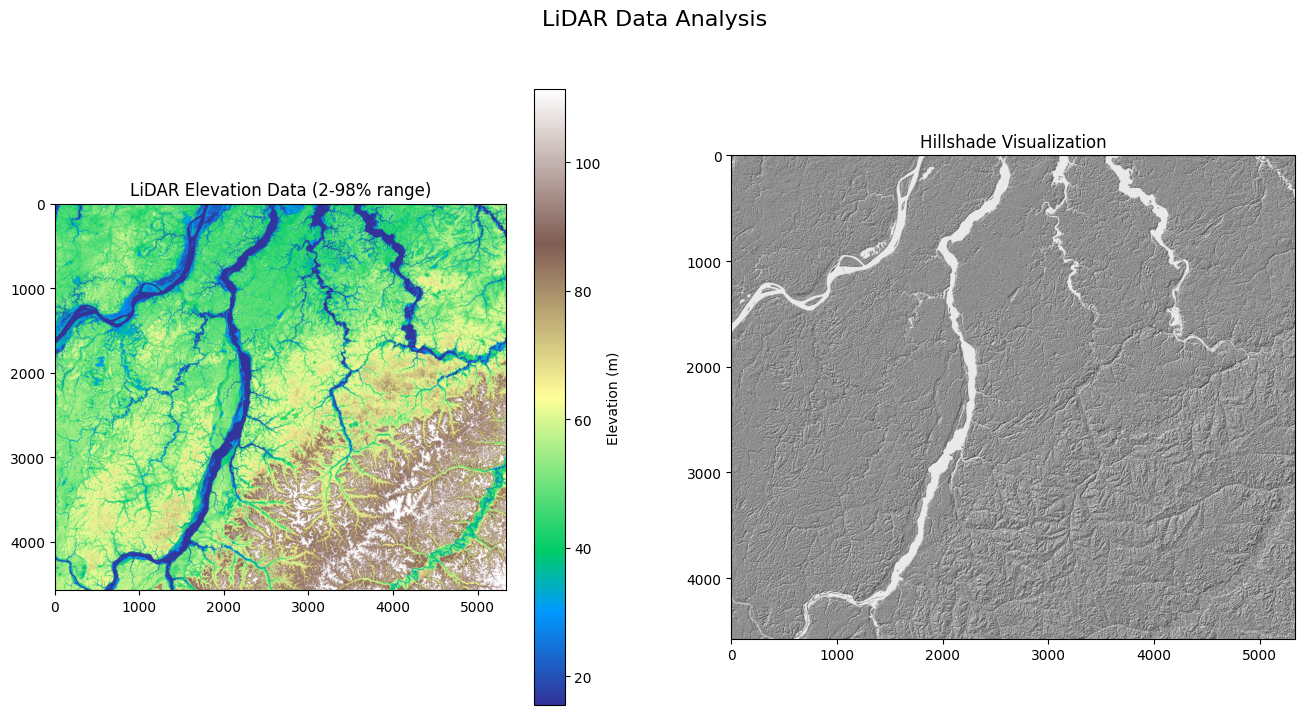

Saving plot to BytesIO buffer...
Converting plot to base64 and computation of stats...
Temporary file /tmp/tmpuu4xicux.tif deleted.
Displaying LiDAR Elevation and Hillshade:


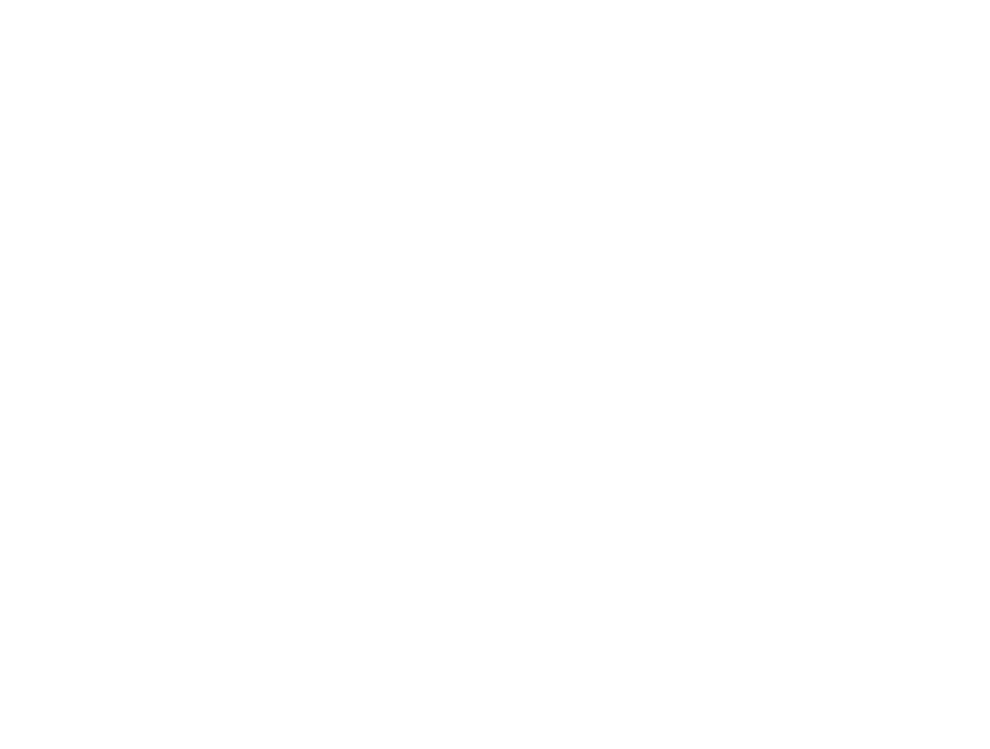

Calculating stats for bands: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'] at 20m scale...
Band stats received.
Computing Normalized Difference Vegetation Index (NDVI)...
NDVI stats received.
Generating RGB composite thumbnail...
RGB composite thumbnail URL (first 100 chars): https://earthengine.googleapis.com/v1/projects/amazon-env/thumbnails/775f3f08e2c6d16d754903e865a8914...
RGB composite thumbnail generated and encoded.
Generating NDVI heatmap visualization...
NDVI thumbnail URL (first 100 chars): https://earthengine.googleapis.com/v1/projects/amazon-env/thumbnails/af82c94bdd17f755d951473881ca983...
NDVI heatmap generated and encoded.
Generating false-color composite (NIR-Red-Green)...
False-color thumbnail URL (first 100 chars): https://earthengine.googleapis.com/v1/projects/amazon-env/thumbnails/9f236580c065dd8b4c3de00f3555bf6...
False-color composite generated and encoded.
Displaying RGB thumbnail...
Displaying NDVI heatmap...
Displaying false-color

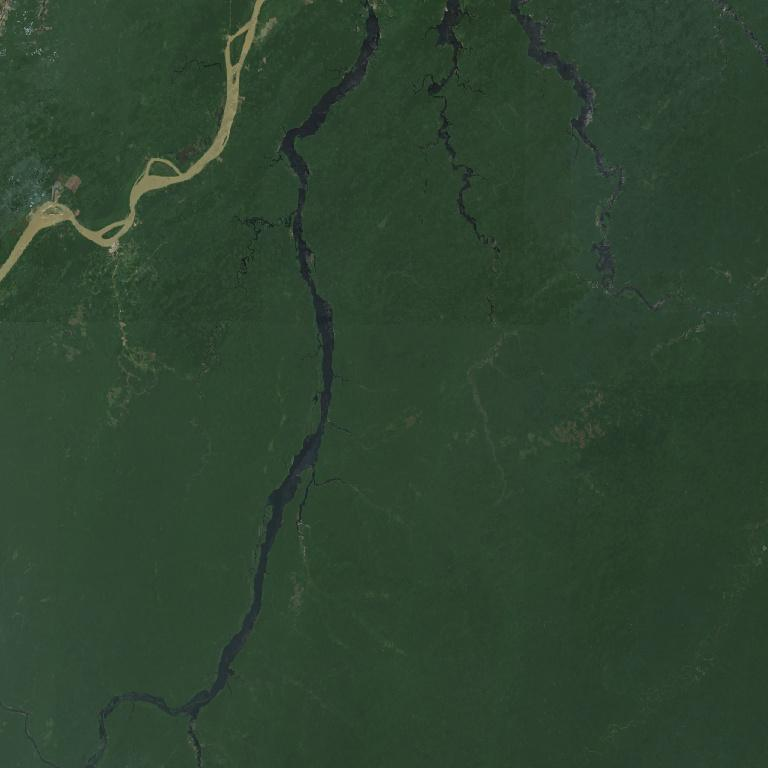

Displaying Sentinel-2 NDVI Heatmap:


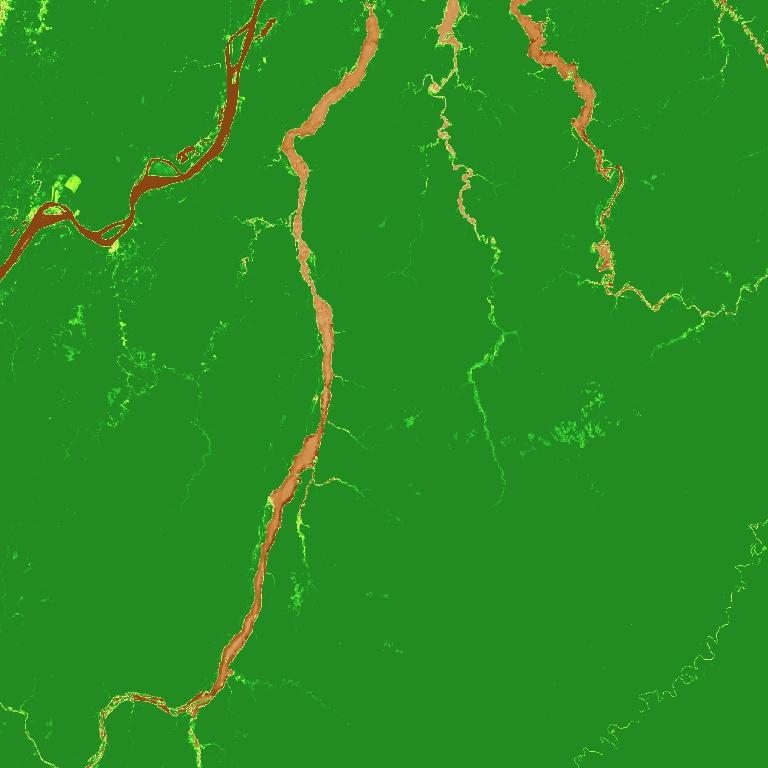

Displaying Sentinel-2 False-Color Composite:


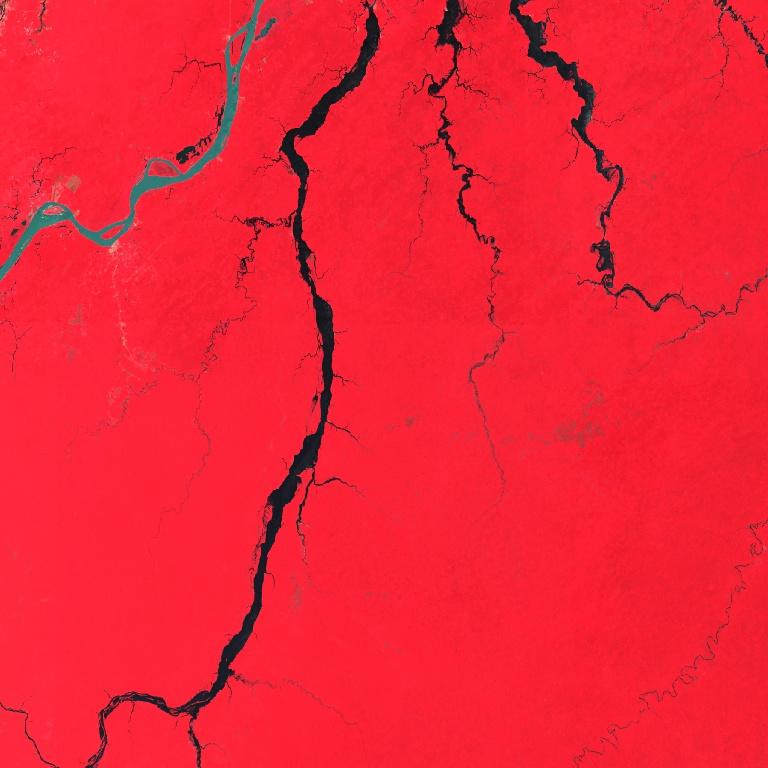



--- Step 4: Engineering per-cell features ---


Generated 2566 per-cell feature vectors.
Sample of engineered features:


,h3_cell,shot_count,mean_canopy_height,std_canopy_height,min_canopy_height,max_canopy_height,mean_rh98,std_rh98,lat,lon,...,height_variability_norm,canopy_height_range_norm,shot_density_norm,rh98_height_difference_norm,deforest_impact_norm,terrain_complexity_norm,canopy_elevation_difference_norm,slope_canopy_interaction_norm,mean_slope_norm,anomaly_potential_norm
0,898aa80284bffff,3,16.1400,3.4272,12.41,19.15,15.5567,3.2984,-4.585272,-59.022653,...,0.197861,0.075854,0.000000,0.935795,0.0,0.0,0.232791,0.0,0.0,0.078140
1,898aa8054d3ffff,3,12.2367,1.1968,11.08,13.47,11.5867,1.2606,-4.516689,-59.044463,...,0.088522,0.025478,0.000000,0.919106,0.0,0.0,0.169935,0.0,0.0,0.026635
2,898aa8070d3ffff,4,15.8100,8.4782,9.13,27.66,15.3550,8.3992,-4.550408,-59.065050,...,0.507257,0.212391,0.142857,0.967898,0.0,0.0,0.227477,0.0,0.0,0.326448
3,898aa80726bffff,4,15.3250,1.8121,13.44,17.73,14.7725,1.7351,-4.519981,-59.044600,...,0.108002,0.047481,0.142857,0.943502,0.0,0.0,0.219667,0.0,0.0,0.157108
4,898aa807467ffff,4,21.9075,2.5446,19.46,24.86,20.9450,2.6231,-4.553457,-59.070657,...,0.106092,0.060336,0.142857,0.840915,0.0,0.0,0.325666,0.0,0.0,0.169714




--- Step 5: Scoring and ranking anomalies ---
Top 3 ranked anomalies:


,h3_cell,score,lat,lon,mean_canopy_height,height_variability,deforest_impact
0,898aa86910bffff,0.429742,-4.083081,-58.644924,49.6333,0.9667,0.0
1,898aa8691abffff,0.422669,-4.084391,-58.653227,42.4933,1.0523,0.0
2,898aa81639bffff,0.403731,-4.697341,-59.134189,24.6067,0.4271,0.0




--- Step 6: Running LLM-based assessment for top 3 cells ---


--- Step 7: Displaying Final Assessment Results ---


## Regional Assessment (from LLM)

## Regional Context Summary - Amazonian Archaeological Potential

This region is characterized by dense, primarily undisturbed rainforest, bisected by a substantial river system (likely a major tributary of the Amazon). Sentinel-2 data indicates consistently high NDVI values (mean 0.796, max 0.919), confirming robust vegetation cover. 

LiDAR statistics reveal a relatively flat landscape with low variance in elevation. However, the consistently high values in bands B6, B7, B8, B8A, B9, and B12 suggest significant moisture content within the vegetation and potentially in underlying soils along the river system – including the floodplain. Notably, B11 values are relatively lower, which could identify slightly differing vegetation compositions or disturbance along the edges of the river.

**Archaeological Implications:**

*   **Riverine Focus:** The extensive river network provides a natural avenue for travel, resource access, and settlement. Archaeological sites are highly likely to be situated *along* the riverbanks and adjacent floodplains where visibility and access are enhanced. Continued riverbank erosion may also be exposing archaeological deposits.
*   **Floodplain Potential:** Areas with high B6-B9 and B12 values represent floodplains. These areas may have preserved organic archaeological remains (e.g., raised fields, middens) due to waterlogged conditions.
*    **Vegetation Complexity:** Mature closed canopy forest, as demonstrated with NDVI, could obscure features and lower the precision of archaeological targets. 
*   **Limited Elevation Change:** The typically flat topography suggests that earthworks or significant landscape manipulations, if present, may be subtle and require high-resolution data for detection.



This regional context suggests a potentially high archaeological sensitivity, particularly along the river corridor. Further cell-level LiDAR analysis focusing on the identification of subtle topographic variations (e.g., raised features, depressions, linear alignments) and anomaly detection within the Sentinel-2 data, as well as a look at multi-temporal data to identify disturbance potential, is recommended.

### LLM Assessment for 898aa86910bffff (Rank 1)

```json
{
  "potential": "medium",
  "rationale": [
    "The mean canopy height of 49.63m, alongside a high canopy height range of 86.54m (normalized to 1.0),  suggests a complex forest structure that could mask subtle archaeological features.",
    "The cell is located adjacent to a river, as evident in the provided imagery, aligning with the regional assessment's focus on riverine archaeological potential.  The anomaly potential score is high (0.9999999999999999)",
    "The moderate B6-B12 band values, indicating moisture content, suggest the potential for floodplain environments where organic remains could be preserved. A high B7 (0.285), B8 (0.288), and B8A (0.318) indicate potential for moisture."
  ],
  "priority": 3
}
```


--------------------------------------------------------------------------------



### LLM Assessment for 898aa8691abffff (Rank 2)

```json
{
  "potential": "medium",
  "rationale": [
    "The `anomaly_potential_norm` is high at 0.9059, indicating a statistically unusual cell based on the combined metric analysis.",
    "The high `canopy_height_range_norm` (0.9028) suggests substantial vertical heterogeneity within the canopy, which could be indicative of human modifications or disturbance, despite the broadly undisturbed classification.",
    "The cell is positioned along the edge of a significant river system, enhancing the likelihood of past human activity as per the regional assessment. The Sentinel-2 imagery confirms this via the extensive branching river system."
  ],
  "priority": 3
}
```


--------------------------------------------------------------------------------



### LLM Assessment for 898aa81639bffff (Rank 3)

```json
{
  "potential": "medium",
  "rationale": [
    "The `anomaly_potential` score of 9.80 suggests a somewhat elevated likelihood of an anthropogenic feature, indicating unusual combinations of characteristics.",
    "The `shot_density` norm is 0.0, suggesting areas of high canopy coverage which could be concealing features, but within the cell, the trio of high B6, B7 and B8 values (0.227, 0.285, 0.287) indicates moisture, possibly a floodplain which might contain remnants of human activity.",
    "The `slope_canopy_interaction_norm` is 1.0 indicating the interaction between canopy and slope is significant. Given the generally flat terrain (mean slope 19.90) but not entirely zero elevation change, this suggests the canopy may be responding to subtle topographic variations potentially caused by earthworks."
  ],
  "priority": 3
}
```


--------------------------------------------------------------------------------



In [19]:
# --- 1. Fetch GEDI, PRODES, and SRTM Data ---
print("--- Step 1: Fetching GEDI, PRODES, SRTM data ---")
gedi_df, prodes_gdf, srtm_df = gedi_prodes_srtm_fetch_pipeline(
    BBOX, YEAR, CACHE_DIR, FORCE_REFRESH
)
print(f"Fetched {len(gedi_df)} GEDI shots, {len(prodes_gdf)} PRODES polygons, {len(srtm_df)} SRTM points")
print("\n")

# --- 2. Fetch Regional LiDAR and Sentinel-2 Data ---
print("--- Step 2: Fetching regional LiDAR and Sentinel-2 data ---")
region_ctx = lidar_sentinel2_fetch_pipeline(BBOX)
print(f"LiDAR path: {region_ctx.get('lidar_path')}")
print(f"S2 data available: {region_ctx.get('s2_data') is not None}")
print("\n")


# --- 3. Extract Regional Features and Display Images ---
print("--- Step 3: Extracting regional features and displaying images ---")
region_features = {}
if region_ctx and region_ctx.get("lidar_path"):
    lidar_stats = lidar_ot_extract_features(region_ctx["lidar_path"], show_image=SHOW_IMAGES)
    if lidar_stats and lidar_stats.get("image"):
        print("Displaying LiDAR Elevation and Hillshade:")
        display(IPImage(base64.b64decode(lidar_stats["image"])))
        region_features.update(lidar_stats)

if region_ctx and region_ctx.get("s2_data"):
    s2_stats = sentinel2_gee_extract_features(region_ctx["s2_data"], show_image=SHOW_IMAGES)
    if s2_stats:
        if s2_stats.get("image"):
            print("Displaying Sentinel-2 RGB Composite:")
            display(IPImage(base64.b64decode(s2_stats["image"])))
        if s2_stats.get("ndvi_image"):
            print("Displaying Sentinel-2 NDVI Heatmap:")
            display(IPImage(base64.b64decode(s2_stats["ndvi_image"])))
        if s2_stats.get("false_color_image"):
            print("Displaying Sentinel-2 False-Color Composite:")
            display(IPImage(base64.b64decode(s2_stats["false_color_image"])))
        region_features.update(s2_stats)
print("\n")


# --- 4. Perform Feature Engineering ---
print("--- Step 4: Engineering per-cell features ---")
features_df = feat_engineering_pipeline(gedi_df, prodes_gdf, srtm_df)
print(f"Generated {len(features_df)} per-cell feature vectors.")
print("Sample of engineered features:")
display(features_df.head())
print("\n")


# --- 5. Score and Rank Anomalies ---
print("--- Step 5: Scoring and ranking anomalies ---")
scored_df = score_cells(features_df, method='weighted')
top_cells_df = rank_cells(scored_df, n=TOP_N)
print(f"Top {TOP_N} ranked anomalies:")
display(top_cells_df[['h3_cell', 'score', 'lat', 'lon', 'mean_canopy_height', 'height_variability', 'deforest_impact']])
print("\n")


# --- 6. Run LLM-Based Assessment ---
print(f"--- Step 6: Running LLM-based assessment for top {TOP_N} cells ---")
llm_results = analyze_top_n_cells_batch(
    top_cells_df.to_dict(orient='records'),
    region_features,
    provider=LLM_PROVIDER,
    model_name=LLM_MODEL,
    save_log=True
)
print("\n")


# --- 7. Display Final Results ---
print("--- Step 7: Displaying Final Assessment Results ---")

if llm_results:
    # Display Regional Assessment
    display(Markdown("## Regional Assessment (from LLM)"))
    display(Markdown(llm_results.get('regional_assessment', 'No regional assessment provided.')))
    print("\n" + "="*80 + "\n")

    # Display Per-Cell Assessments
    cell_assessments = llm_results.get("cell_assessments", [])
    for i, entry in enumerate(cell_assessments):
        cell_id = entry.get('cell_id', f'Cell {i+1}')
        display(Markdown(f"### LLM Assessment for {cell_id} (Rank {i+1})"))

        try:
            # The response is often a stringified JSON, so we parse it
            response_json = json.loads(entry.get('llm_response', '{}'))
            display(JSON(response_json))
        except json.JSONDecodeError:
            # If it's not JSON, display as markdown
            display(Markdown(entry.get('llm_response', 'No response')))

        print("\n" + "-"*80 + "\n")
else:
    print("LLM analysis was not run or failed.")